In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1t2_native_k5_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 1576)
(657450, 8)
validation
(74368, 1576)
(74368, 8)
test
(91684, 1576)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2304904 (8.79 MB)


Trainable params: 2304904 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:56 - loss: 2.0869 - STD: 0.0928 - MAE: 0.2165

 3/66 [>.............................] - ETA: 2s - loss: 1.6937 - STD: 0.1150 - MAE: 0.1881  

 5/66 [=>............................] - ETA: 2s - loss: 1.5643 - STD: 0.1580 - MAE: 0.1664

 7/66 [==>...........................] - ETA: 2s - loss: 1.5066 - STD: 0.1811 - MAE: 0.1554

 9/66 [===>..........................] - ETA: 2s - loss: 1.4652 - STD: 0.1890 - MAE: 0.1509

11/66 [====>.........................] - ETA: 1s - loss: 1.4355 - STD: 0.1881 - MAE: 0.1503

13/66 [====>.........................] - ETA: 1s - loss: 1.4173 - STD: 0.1850 - MAE: 0.1508

15/66 [=====>........................] - ETA: 1s - loss: 1.4054 - STD: 0.1834 - MAE: 0.1511

17/66 [======>.......................] - ETA: 1s - loss: 1.3931 - STD: 0.1841 - MAE: 0.1504

19/66 [=======>......................] - ETA: 1s - loss: 1.3849 - STD: 0.1863 - MAE: 0.1493

21/66 [========>.....................] - ETA: 1s - loss: 1.3783 - STD: 0.1890 - MAE: 0.1480

23/66 [=========>....................] - ETA: 1s - loss: 1.3732 - STD: 0.1910 - MAE: 0.1471

25/66 [==========>...................] - ETA: 1s - loss: 1.3693 - STD: 0.1919 - MAE: 0.1467

27/66 [===========>..................] - ETA: 1s - loss: 1.3644 - STD: 0.1918 - MAE: 0.1465

29/66 [============>.................] - ETA: 1s - loss: 1.3617 - STD: 0.1912 - MAE: 0.1467

31/66 [=============>................] - ETA: 1s - loss: 1.3578 - STD: 0.1907 - MAE: 0.1467

33/66 [==============>...............] - ETA: 1s - loss: 1.3552 - STD: 0.1907 - MAE: 0.1467

35/66 [==============>...............] - ETA: 1s - loss: 1.3528 - STD: 0.1911 - MAE: 0.1465

37/66 [===============>..............] - ETA: 1s - loss: 1.3511 - STD: 0.1916 - MAE: 0.1463

39/66 [================>.............] - ETA: 0s - loss: 1.3498 - STD: 0.1920 - MAE: 0.1461

41/66 [=================>............] - ETA: 0s - loss: 1.3484 - STD: 0.1921 - MAE: 0.1461

43/66 [==================>...........] - ETA: 0s - loss: 1.3466 - STD: 0.1919 - MAE: 0.1461

45/66 [===================>..........] - ETA: 0s - loss: 1.3454 - STD: 0.1916 - MAE: 0.1462

47/66 [====================>.........] - ETA: 0s - loss: 1.3442 - STD: 0.1914 - MAE: 0.1462

49/66 [=====================>........] - ETA: 0s - loss: 1.3428 - STD: 0.1914 - MAE: 0.1462

51/66 [======================>.......] - ETA: 0s - loss: 1.3415 - STD: 0.1915 - MAE: 0.1461

53/66 [=======================>......] - ETA: 0s - loss: 1.3404 - STD: 0.1916 - MAE: 0.1460

55/66 [========================>.....] - ETA: 0s - loss: 1.3390 - STD: 0.1917 - MAE: 0.1460

57/66 [========================>.....] - ETA: 0s - loss: 1.3379 - STD: 0.1917 - MAE: 0.1459

59/66 [=========================>....] - ETA: 0s - loss: 1.3368 - STD: 0.1916 - MAE: 0.1459

61/66 [==========================>...] - ETA: 0s - loss: 1.3359 - STD: 0.1916 - MAE: 0.1459

63/66 [===========================>..] - ETA: 0s - loss: 1.3357 - STD: 0.1916 - MAE: 0.1459

65/66 [============================>.] - ETA: 0s - loss: 1.3350 - STD: 0.1915 - MAE: 0.1459

66/66 [==============================] - 6s 67ms/step - loss: 1.3347 - STD: 0.1915 - MAE: 0.1459 - val_loss: 1.2452 - val_STD: 0.1901 - val_MAE: 0.1426


Epoch 2/10000


 1/66 [..............................] - ETA: 5s - loss: 1.3132 - STD: 0.1901 - MAE: 0.1463

 3/66 [>.............................] - ETA: 2s - loss: 1.3071 - STD: 0.1900 - MAE: 0.1459

 5/66 [=>............................] - ETA: 2s - loss: 1.3089 - STD: 0.1904 - MAE: 0.1457

 7/66 [==>...........................] - ETA: 2s - loss: 1.3075 - STD: 0.1910 - MAE: 0.1453

 9/66 [===>..........................] - ETA: 2s - loss: 1.3052 - STD: 0.1917 - MAE: 0.1449

11/66 [====>.........................] - ETA: 1s - loss: 1.3038 - STD: 0.1923 - MAE: 0.1447

13/66 [====>.........................] - ETA: 1s - loss: 1.3019 - STD: 0.1926 - MAE: 0.1445

15/66 [=====>........................] - ETA: 1s - loss: 1.3037 - STD: 0.1927 - MAE: 0.1445

17/66 [======>.......................] - ETA: 1s - loss: 1.3039 - STD: 0.1926 - MAE: 0.1445

19/66 [=======>......................] - ETA: 1s - loss: 1.3066 - STD: 0.1925 - MAE: 0.1447

21/66 [========>.....................] - ETA: 1s - loss: 1.3069 - STD: 0.1922 - MAE: 0.1448

23/66 [=========>....................] - ETA: 1s - loss: 1.3070 - STD: 0.1920 - MAE: 0.1449

25/66 [==========>...................] - ETA: 1s - loss: 1.3077 - STD: 0.1920 - MAE: 0.1450

27/66 [===========>..................] - ETA: 1s - loss: 1.3090 - STD: 0.1920 - MAE: 0.1450

29/66 [============>.................] - ETA: 1s - loss: 1.3090 - STD: 0.1920 - MAE: 0.1450

31/66 [=============>................] - ETA: 1s - loss: 1.3086 - STD: 0.1921 - MAE: 0.1450

33/66 [==============>...............] - ETA: 1s - loss: 1.3095 - STD: 0.1921 - MAE: 0.1450

35/66 [==============>...............] - ETA: 1s - loss: 1.3096 - STD: 0.1920 - MAE: 0.1451

37/66 [===============>..............] - ETA: 1s - loss: 1.3092 - STD: 0.1918 - MAE: 0.1451

39/66 [================>.............] - ETA: 0s - loss: 1.3093 - STD: 0.1917 - MAE: 0.1452

41/66 [=================>............] - ETA: 0s - loss: 1.3096 - STD: 0.1918 - MAE: 0.1452

43/66 [==================>...........] - ETA: 0s - loss: 1.3090 - STD: 0.1918 - MAE: 0.1451

45/66 [===================>..........] - ETA: 0s - loss: 1.3090 - STD: 0.1919 - MAE: 0.1451

47/66 [====================>.........] - ETA: 0s - loss: 1.3091 - STD: 0.1920 - MAE: 0.1451

49/66 [=====================>........] - ETA: 0s - loss: 1.3093 - STD: 0.1919 - MAE: 0.1451

51/66 [======================>.......] - ETA: 0s - loss: 1.3091 - STD: 0.1918 - MAE: 0.1451

53/66 [=======================>......] - ETA: 0s - loss: 1.3089 - STD: 0.1918 - MAE: 0.1451

55/66 [========================>.....] - ETA: 0s - loss: 1.3085 - STD: 0.1919 - MAE: 0.1450

57/66 [========================>.....] - ETA: 0s - loss: 1.3087 - STD: 0.1920 - MAE: 0.1450

59/66 [=========================>....] - ETA: 0s - loss: 1.3085 - STD: 0.1920 - MAE: 0.1450

61/66 [==========================>...] - ETA: 0s - loss: 1.3085 - STD: 0.1920 - MAE: 0.1450

63/66 [===========================>..] - ETA: 0s - loss: 1.3080 - STD: 0.1919 - MAE: 0.1450

65/66 [============================>.] - ETA: 0s - loss: 1.3084 - STD: 0.1920 - MAE: 0.1450

66/66 [==============================] - 3s 40ms/step - loss: 1.3083 - STD: 0.1920 - MAE: 0.1450 - val_loss: 1.2445 - val_STD: 0.1932 - val_MAE: 0.1413


Epoch 3/10000


 1/66 [..............................] - ETA: 4s - loss: 1.3302 - STD: 0.1932 - MAE: 0.1459

 3/66 [>.............................] - ETA: 2s - loss: 1.3154 - STD: 0.1921 - MAE: 0.1454

 5/66 [=>............................] - ETA: 2s - loss: 1.3120 - STD: 0.1915 - MAE: 0.1453

 7/66 [==>...........................] - ETA: 2s - loss: 1.3123 - STD: 0.1916 - MAE: 0.1454

 9/66 [===>..........................] - ETA: 2s - loss: 1.3109 - STD: 0.1918 - MAE: 0.1452

11/66 [====>.........................] - ETA: 1s - loss: 1.3090 - STD: 0.1919 - MAE: 0.1451

13/66 [====>.........................] - ETA: 1s - loss: 1.3102 - STD: 0.1920 - MAE: 0.1451

15/66 [=====>........................] - ETA: 1s - loss: 1.3083 - STD: 0.1921 - MAE: 0.1449

17/66 [======>.......................] - ETA: 1s - loss: 1.3088 - STD: 0.1923 - MAE: 0.1449

19/66 [=======>......................] - ETA: 1s - loss: 1.3074 - STD: 0.1923 - MAE: 0.1448

21/66 [========>.....................] - ETA: 1s - loss: 1.3077 - STD: 0.1923 - MAE: 0.1448

23/66 [=========>....................] - ETA: 1s - loss: 1.3072 - STD: 0.1923 - MAE: 0.1448

25/66 [==========>...................] - ETA: 1s - loss: 1.3067 - STD: 0.1923 - MAE: 0.1448

27/66 [===========>..................] - ETA: 1s - loss: 1.3067 - STD: 0.1923 - MAE: 0.1448

29/66 [============>.................] - ETA: 1s - loss: 1.3061 - STD: 0.1923 - MAE: 0.1448

31/66 [=============>................] - ETA: 1s - loss: 1.3055 - STD: 0.1922 - MAE: 0.1448

33/66 [==============>...............] - ETA: 1s - loss: 1.3055 - STD: 0.1923 - MAE: 0.1447

35/66 [==============>...............] - ETA: 1s - loss: 1.3059 - STD: 0.1924 - MAE: 0.1447

37/66 [===============>..............] - ETA: 1s - loss: 1.3062 - STD: 0.1924 - MAE: 0.1447

39/66 [================>.............] - ETA: 0s - loss: 1.3059 - STD: 0.1923 - MAE: 0.1447

41/66 [=================>............] - ETA: 0s - loss: 1.3061 - STD: 0.1923 - MAE: 0.1448

43/66 [==================>...........] - ETA: 0s - loss: 1.3066 - STD: 0.1924 - MAE: 0.1448

45/66 [===================>..........] - ETA: 0s - loss: 1.3073 - STD: 0.1923 - MAE: 0.1448

47/66 [====================>.........] - ETA: 0s - loss: 1.3073 - STD: 0.1921 - MAE: 0.1449

49/66 [=====================>........] - ETA: 0s - loss: 1.3071 - STD: 0.1921 - MAE: 0.1449

51/66 [======================>.......] - ETA: 0s - loss: 1.3074 - STD: 0.1922 - MAE: 0.1449

53/66 [=======================>......] - ETA: 0s - loss: 1.3075 - STD: 0.1923 - MAE: 0.1449

55/66 [========================>.....] - ETA: 0s - loss: 1.3072 - STD: 0.1922 - MAE: 0.1449

57/66 [========================>.....] - ETA: 0s - loss: 1.3078 - STD: 0.1921 - MAE: 0.1449

59/66 [=========================>....] - ETA: 0s - loss: 1.3076 - STD: 0.1921 - MAE: 0.1449

61/66 [==========================>...] - ETA: 0s - loss: 1.3076 - STD: 0.1921 - MAE: 0.1449

63/66 [===========================>..] - ETA: 0s - loss: 1.3079 - STD: 0.1921 - MAE: 0.1449

65/66 [============================>.] - ETA: 0s - loss: 1.3081 - STD: 0.1921 - MAE: 0.1450

66/66 [==============================] - 3s 40ms/step - loss: 1.3082 - STD: 0.1921 - MAE: 0.1450 - val_loss: 1.2459 - val_STD: 0.1882 - val_MAE: 0.1433


Epoch 4/10000


 1/66 [..............................] - ETA: 5s - loss: 1.3019 - STD: 0.1883 - MAE: 0.1460

 3/66 [>.............................] - ETA: 2s - loss: 1.3134 - STD: 0.1895 - MAE: 0.1462

 5/66 [=>............................] - ETA: 2s - loss: 1.3088 - STD: 0.1908 - MAE: 0.1455

 7/66 [==>...........................] - ETA: 2s - loss: 1.3078 - STD: 0.1917 - MAE: 0.1451

 9/66 [===>..........................] - ETA: 2s - loss: 1.3107 - STD: 0.1918 - MAE: 0.1452

11/66 [====>.........................] - ETA: 2s - loss: 1.3106 - STD: 0.1912 - MAE: 0.1455

13/66 [====>.........................] - ETA: 1s - loss: 1.3094 - STD: 0.1908 - MAE: 0.1456

15/66 [=====>........................] - ETA: 1s - loss: 1.3094 - STD: 0.1912 - MAE: 0.1454

17/66 [======>.......................] - ETA: 1s - loss: 1.3087 - STD: 0.1918 - MAE: 0.1452

19/66 [=======>......................] - ETA: 1s - loss: 1.3086 - STD: 0.1919 - MAE: 0.1451

21/66 [========>.....................] - ETA: 1s - loss: 1.3086 - STD: 0.1917 - MAE: 0.1452

23/66 [=========>....................] - ETA: 1s - loss: 1.3087 - STD: 0.1916 - MAE: 0.1452

25/66 [==========>...................] - ETA: 1s - loss: 1.3094 - STD: 0.1917 - MAE: 0.1452

27/66 [===========>..................] - ETA: 1s - loss: 1.3094 - STD: 0.1916 - MAE: 0.1452

29/66 [============>.................] - ETA: 1s - loss: 1.3096 - STD: 0.1916 - MAE: 0.1452

31/66 [=============>................] - ETA: 1s - loss: 1.3096 - STD: 0.1916 - MAE: 0.1452

33/66 [==============>...............] - ETA: 1s - loss: 1.3092 - STD: 0.1916 - MAE: 0.1452

35/66 [==============>...............] - ETA: 1s - loss: 1.3078 - STD: 0.1917 - MAE: 0.1451

37/66 [===============>..............] - ETA: 1s - loss: 1.3083 - STD: 0.1918 - MAE: 0.1451

39/66 [================>.............] - ETA: 0s - loss: 1.3077 - STD: 0.1917 - MAE: 0.1451

41/66 [=================>............] - ETA: 0s - loss: 1.3071 - STD: 0.1918 - MAE: 0.1450

43/66 [==================>...........] - ETA: 0s - loss: 1.3063 - STD: 0.1918 - MAE: 0.1450

45/66 [===================>..........] - ETA: 0s - loss: 1.3055 - STD: 0.1920 - MAE: 0.1448

47/66 [====================>.........] - ETA: 0s - loss: 1.3051 - STD: 0.1920 - MAE: 0.1448

49/66 [=====================>........] - ETA: 0s - loss: 1.3045 - STD: 0.1921 - MAE: 0.1447

51/66 [======================>.......] - ETA: 0s - loss: 1.3042 - STD: 0.1920 - MAE: 0.1448

53/66 [=======================>......] - ETA: 0s - loss: 1.3035 - STD: 0.1921 - MAE: 0.1447

55/66 [========================>.....] - ETA: 0s - loss: 1.3028 - STD: 0.1920 - MAE: 0.1447

57/66 [========================>.....] - ETA: 0s - loss: 1.3027 - STD: 0.1921 - MAE: 0.1446

59/66 [=========================>....] - ETA: 0s - loss: 1.3021 - STD: 0.1920 - MAE: 0.1446

61/66 [==========================>...] - ETA: 0s - loss: 1.3012 - STD: 0.1921 - MAE: 0.1445

63/66 [===========================>..] - ETA: 0s - loss: 1.3011 - STD: 0.1921 - MAE: 0.1445

65/66 [============================>.] - ETA: 0s - loss: 1.3008 - STD: 0.1921 - MAE: 0.1445

66/66 [==============================] - 3s 42ms/step - loss: 1.3001 - STD: 0.1921 - MAE: 0.1445 - val_loss: 1.2021 - val_STD: 0.2031 - val_MAE: 0.1350


Epoch 5/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2475 - STD: 0.2024 - MAE: 0.1374

 3/66 [>.............................] - ETA: 2s - loss: 1.2548 - STD: 0.1963 - MAE: 0.1403

 5/66 [=>............................] - ETA: 2s - loss: 1.2589 - STD: 0.1949 - MAE: 0.1410

 7/66 [==>...........................] - ETA: 2s - loss: 1.2584 - STD: 0.1961 - MAE: 0.1405

 9/66 [===>..........................] - ETA: 2s - loss: 1.2587 - STD: 0.1974 - MAE: 0.1400

11/66 [====>.........................] - ETA: 1s - loss: 1.2597 - STD: 0.1960 - MAE: 0.1406

13/66 [====>.........................] - ETA: 1s - loss: 1.2593 - STD: 0.1968 - MAE: 0.1403

15/66 [=====>........................] - ETA: 1s - loss: 1.2609 - STD: 0.1970 - MAE: 0.1403

17/66 [======>.......................] - ETA: 1s - loss: 1.2613 - STD: 0.1971 - MAE: 0.1402

19/66 [=======>......................] - ETA: 1s - loss: 1.2607 - STD: 0.1978 - MAE: 0.1400

21/66 [========>.....................] - ETA: 1s - loss: 1.2616 - STD: 0.1972 - MAE: 0.1402

23/66 [=========>....................] - ETA: 1s - loss: 1.2604 - STD: 0.1979 - MAE: 0.1399

25/66 [==========>...................] - ETA: 1s - loss: 1.2604 - STD: 0.1975 - MAE: 0.1401

27/66 [===========>..................] - ETA: 1s - loss: 1.2604 - STD: 0.1981 - MAE: 0.1399

29/66 [============>.................] - ETA: 1s - loss: 1.2603 - STD: 0.1974 - MAE: 0.1402

31/66 [=============>................] - ETA: 1s - loss: 1.2603 - STD: 0.1978 - MAE: 0.1400

33/66 [==============>...............] - ETA: 1s - loss: 1.2604 - STD: 0.1975 - MAE: 0.1402

35/66 [==============>...............] - ETA: 1s - loss: 1.2603 - STD: 0.1975 - MAE: 0.1401

37/66 [===============>..............] - ETA: 1s - loss: 1.2596 - STD: 0.1980 - MAE: 0.1399

39/66 [================>.............] - ETA: 0s - loss: 1.2593 - STD: 0.1976 - MAE: 0.1401

41/66 [=================>............] - ETA: 0s - loss: 1.2584 - STD: 0.1982 - MAE: 0.1398

43/66 [==================>...........] - ETA: 0s - loss: 1.2576 - STD: 0.1976 - MAE: 0.1400

45/66 [===================>..........] - ETA: 0s - loss: 1.2569 - STD: 0.1980 - MAE: 0.1399

47/66 [====================>.........] - ETA: 0s - loss: 1.2558 - STD: 0.1980 - MAE: 0.1398

49/66 [=====================>........] - ETA: 0s - loss: 1.2549 - STD: 0.1980 - MAE: 0.1398

51/66 [======================>.......] - ETA: 0s - loss: 1.2541 - STD: 0.1983 - MAE: 0.1396

53/66 [=======================>......] - ETA: 0s - loss: 1.2536 - STD: 0.1982 - MAE: 0.1397

55/66 [========================>.....] - ETA: 0s - loss: 1.2531 - STD: 0.1984 - MAE: 0.1396

57/66 [========================>.....] - ETA: 0s - loss: 1.2524 - STD: 0.1984 - MAE: 0.1396

59/66 [=========================>....] - ETA: 0s - loss: 1.2514 - STD: 0.1984 - MAE: 0.1395

61/66 [==========================>...] - ETA: 0s - loss: 1.2512 - STD: 0.1985 - MAE: 0.1395

63/66 [===========================>..] - ETA: 0s - loss: 1.2509 - STD: 0.1985 - MAE: 0.1395

65/66 [============================>.] - ETA: 0s - loss: 1.2499 - STD: 0.1985 - MAE: 0.1395

66/66 [==============================] - 3s 41ms/step - loss: 1.2496 - STD: 0.1986 - MAE: 0.1394 - val_loss: 1.1551 - val_STD: 0.1962 - val_MAE: 0.1362


Epoch 6/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2106 - STD: 0.1949 - MAE: 0.1396

 3/66 [>.............................] - ETA: 2s - loss: 1.2100 - STD: 0.2030 - MAE: 0.1363

 5/66 [=>............................] - ETA: 2s - loss: 1.2224 - STD: 0.2029 - MAE: 0.1368

 7/66 [==>...........................] - ETA: 2s - loss: 1.2245 - STD: 0.1986 - MAE: 0.1386

 9/66 [===>..........................] - ETA: 2s - loss: 1.2253 - STD: 0.2002 - MAE: 0.1380

11/66 [====>.........................] - ETA: 1s - loss: 1.2227 - STD: 0.2002 - MAE: 0.1378

13/66 [====>.........................] - ETA: 1s - loss: 1.2262 - STD: 0.1996 - MAE: 0.1383

15/66 [=====>........................] - ETA: 1s - loss: 1.2280 - STD: 0.2007 - MAE: 0.1380

17/66 [======>.......................] - ETA: 1s - loss: 1.2267 - STD: 0.1995 - MAE: 0.1384

19/66 [=======>......................] - ETA: 1s - loss: 1.2263 - STD: 0.2002 - MAE: 0.1381

21/66 [========>.....................] - ETA: 1s - loss: 1.2253 - STD: 0.1998 - MAE: 0.1382

23/66 [=========>....................] - ETA: 1s - loss: 1.2249 - STD: 0.2006 - MAE: 0.1379

25/66 [==========>...................] - ETA: 1s - loss: 1.2245 - STD: 0.2002 - MAE: 0.1381

27/66 [===========>..................] - ETA: 1s - loss: 1.2248 - STD: 0.2002 - MAE: 0.1381

29/66 [============>.................] - ETA: 1s - loss: 1.2242 - STD: 0.2000 - MAE: 0.1382

31/66 [=============>................] - ETA: 1s - loss: 1.2241 - STD: 0.2000 - MAE: 0.1382

33/66 [==============>...............] - ETA: 1s - loss: 1.2235 - STD: 0.2002 - MAE: 0.1381

35/66 [==============>...............] - ETA: 1s - loss: 1.2225 - STD: 0.2003 - MAE: 0.1380

37/66 [===============>..............] - ETA: 1s - loss: 1.2222 - STD: 0.2001 - MAE: 0.1381

39/66 [================>.............] - ETA: 0s - loss: 1.2220 - STD: 0.2001 - MAE: 0.1382

41/66 [=================>............] - ETA: 0s - loss: 1.2217 - STD: 0.2000 - MAE: 0.1382

43/66 [==================>...........] - ETA: 0s - loss: 1.2213 - STD: 0.2001 - MAE: 0.1382

45/66 [===================>..........] - ETA: 0s - loss: 1.2211 - STD: 0.2003 - MAE: 0.1381

47/66 [====================>.........] - ETA: 0s - loss: 1.2204 - STD: 0.2002 - MAE: 0.1381

49/66 [=====================>........] - ETA: 0s - loss: 1.2200 - STD: 0.2001 - MAE: 0.1381

51/66 [======================>.......] - ETA: 0s - loss: 1.2194 - STD: 0.2003 - MAE: 0.1380

53/66 [=======================>......] - ETA: 0s - loss: 1.2185 - STD: 0.2004 - MAE: 0.1380

55/66 [========================>.....] - ETA: 0s - loss: 1.2181 - STD: 0.2003 - MAE: 0.1380

57/66 [========================>.....] - ETA: 0s - loss: 1.2178 - STD: 0.2003 - MAE: 0.1380

59/66 [=========================>....] - ETA: 0s - loss: 1.2174 - STD: 0.2004 - MAE: 0.1380

61/66 [==========================>...] - ETA: 0s - loss: 1.2172 - STD: 0.2003 - MAE: 0.1380

63/66 [===========================>..] - ETA: 0s - loss: 1.2164 - STD: 0.2005 - MAE: 0.1379

65/66 [============================>.] - ETA: 0s - loss: 1.2163 - STD: 0.2004 - MAE: 0.1379

66/66 [==============================] - 3s 41ms/step - loss: 1.2162 - STD: 0.2005 - MAE: 0.1379 - val_loss: 1.1359 - val_STD: 0.1901 - val_MAE: 0.1381


Epoch 7/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2088 - STD: 0.1896 - MAE: 0.1419

 3/66 [>.............................] - ETA: 2s - loss: 1.2012 - STD: 0.2033 - MAE: 0.1362

 5/66 [=>............................] - ETA: 2s - loss: 1.2046 - STD: 0.1999 - MAE: 0.1378

 7/66 [==>...........................] - ETA: 2s - loss: 1.2077 - STD: 0.1997 - MAE: 0.1380

 9/66 [===>..........................] - ETA: 2s - loss: 1.2062 - STD: 0.2007 - MAE: 0.1376

11/66 [====>.........................] - ETA: 1s - loss: 1.2057 - STD: 0.2002 - MAE: 0.1378

13/66 [====>.........................] - ETA: 1s - loss: 1.2047 - STD: 0.2008 - MAE: 0.1375

15/66 [=====>........................] - ETA: 1s - loss: 1.2039 - STD: 0.2003 - MAE: 0.1377

17/66 [======>.......................] - ETA: 1s - loss: 1.2016 - STD: 0.2007 - MAE: 0.1375

19/66 [=======>......................] - ETA: 1s - loss: 1.2016 - STD: 0.2010 - MAE: 0.1374

21/66 [========>.....................] - ETA: 1s - loss: 1.2013 - STD: 0.2007 - MAE: 0.1375

23/66 [=========>....................] - ETA: 1s - loss: 1.2005 - STD: 0.2009 - MAE: 0.1374

25/66 [==========>...................] - ETA: 1s - loss: 1.1992 - STD: 0.2011 - MAE: 0.1372

27/66 [===========>..................] - ETA: 1s - loss: 1.1990 - STD: 0.2011 - MAE: 0.1372

29/66 [============>.................] - ETA: 1s - loss: 1.1982 - STD: 0.2013 - MAE: 0.1371

31/66 [=============>................] - ETA: 1s - loss: 1.1976 - STD: 0.2015 - MAE: 0.1370

33/66 [==============>...............] - ETA: 1s - loss: 1.1982 - STD: 0.2014 - MAE: 0.1371

35/66 [==============>...............] - ETA: 1s - loss: 1.1986 - STD: 0.2012 - MAE: 0.1372

37/66 [===============>..............] - ETA: 1s - loss: 1.1977 - STD: 0.2013 - MAE: 0.1371

39/66 [================>.............] - ETA: 0s - loss: 1.1975 - STD: 0.2012 - MAE: 0.1372

41/66 [=================>............] - ETA: 0s - loss: 1.1975 - STD: 0.2011 - MAE: 0.1372

43/66 [==================>...........] - ETA: 0s - loss: 1.1968 - STD: 0.2014 - MAE: 0.1371

45/66 [===================>..........] - ETA: 0s - loss: 1.1965 - STD: 0.2013 - MAE: 0.1371

47/66 [====================>.........] - ETA: 0s - loss: 1.1963 - STD: 0.2014 - MAE: 0.1371

49/66 [=====================>........] - ETA: 0s - loss: 1.1958 - STD: 0.2014 - MAE: 0.1371

51/66 [======================>.......] - ETA: 0s - loss: 1.1954 - STD: 0.2014 - MAE: 0.1371

53/66 [=======================>......] - ETA: 0s - loss: 1.1952 - STD: 0.2015 - MAE: 0.1370

55/66 [========================>.....] - ETA: 0s - loss: 1.1948 - STD: 0.2015 - MAE: 0.1370

57/66 [========================>.....] - ETA: 0s - loss: 1.1945 - STD: 0.2015 - MAE: 0.1370

59/66 [=========================>....] - ETA: 0s - loss: 1.1937 - STD: 0.2016 - MAE: 0.1369

61/66 [==========================>...] - ETA: 0s - loss: 1.1935 - STD: 0.2017 - MAE: 0.1369

63/66 [===========================>..] - ETA: 0s - loss: 1.1929 - STD: 0.2016 - MAE: 0.1369

65/66 [============================>.] - ETA: 0s - loss: 1.1926 - STD: 0.2017 - MAE: 0.1368

66/66 [==============================] - 3s 41ms/step - loss: 1.1925 - STD: 0.2017 - MAE: 0.1369 - val_loss: 1.1122 - val_STD: 0.2006 - val_MAE: 0.1332


Epoch 8/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1838 - STD: 0.2007 - MAE: 0.1372

 3/66 [>.............................] - ETA: 2s - loss: 1.1856 - STD: 0.2033 - MAE: 0.1362

 5/66 [=>............................] - ETA: 2s - loss: 1.1820 - STD: 0.2016 - MAE: 0.1368

 6/66 [=>............................] - ETA: 2s - loss: 1.1807 - STD: 0.2026 - MAE: 0.1363

 8/66 [==>...........................] - ETA: 2s - loss: 1.1795 - STD: 0.2025 - MAE: 0.1362

10/66 [===>..........................] - ETA: 2s - loss: 1.1763 - STD: 0.2030 - MAE: 0.1359

12/66 [====>.........................] - ETA: 2s - loss: 1.1787 - STD: 0.2031 - MAE: 0.1359

14/66 [=====>........................] - ETA: 2s - loss: 1.1792 - STD: 0.2026 - MAE: 0.1362

16/66 [======>.......................] - ETA: 2s - loss: 1.1780 - STD: 0.2027 - MAE: 0.1361

18/66 [=======>......................] - ETA: 2s - loss: 1.1772 - STD: 0.2029 - MAE: 0.1360

20/66 [========>.....................] - ETA: 1s - loss: 1.1765 - STD: 0.2025 - MAE: 0.1361

22/66 [=========>....................] - ETA: 1s - loss: 1.1768 - STD: 0.2028 - MAE: 0.1360

24/66 [=========>....................] - ETA: 1s - loss: 1.1752 - STD: 0.2028 - MAE: 0.1359

26/66 [==========>...................] - ETA: 1s - loss: 1.1746 - STD: 0.2032 - MAE: 0.1357

28/66 [===========>..................] - ETA: 1s - loss: 1.1747 - STD: 0.2026 - MAE: 0.1360

30/66 [============>.................] - ETA: 1s - loss: 1.1755 - STD: 0.2025 - MAE: 0.1361

32/66 [=============>................] - ETA: 1s - loss: 1.1753 - STD: 0.2029 - MAE: 0.1359

34/66 [==============>...............] - ETA: 1s - loss: 1.1761 - STD: 0.2029 - MAE: 0.1359

36/66 [===============>..............] - ETA: 1s - loss: 1.1762 - STD: 0.2024 - MAE: 0.1361

38/66 [================>.............] - ETA: 1s - loss: 1.1765 - STD: 0.2027 - MAE: 0.1360

40/66 [=================>............] - ETA: 1s - loss: 1.1768 - STD: 0.2024 - MAE: 0.1361

42/66 [==================>...........] - ETA: 1s - loss: 1.1777 - STD: 0.2027 - MAE: 0.1360

44/66 [===================>..........] - ETA: 0s - loss: 1.1773 - STD: 0.2024 - MAE: 0.1361

46/66 [===================>..........] - ETA: 0s - loss: 1.1767 - STD: 0.2029 - MAE: 0.1359

48/66 [====================>.........] - ETA: 0s - loss: 1.1761 - STD: 0.2027 - MAE: 0.1360

50/66 [=====================>........] - ETA: 0s - loss: 1.1751 - STD: 0.2028 - MAE: 0.1359

52/66 [======================>.......] - ETA: 0s - loss: 1.1745 - STD: 0.2029 - MAE: 0.1358

54/66 [=======================>......] - ETA: 0s - loss: 1.1741 - STD: 0.2027 - MAE: 0.1359

56/66 [========================>.....] - ETA: 0s - loss: 1.1735 - STD: 0.2031 - MAE: 0.1357

58/66 [=========================>....] - ETA: 0s - loss: 1.1729 - STD: 0.2027 - MAE: 0.1358

60/66 [==========================>...] - ETA: 0s - loss: 1.1725 - STD: 0.2030 - MAE: 0.1357

62/66 [===========================>..] - ETA: 0s - loss: 1.1719 - STD: 0.2029 - MAE: 0.1357

64/66 [============================>.] - ETA: 0s - loss: 1.1714 - STD: 0.2029 - MAE: 0.1357

66/66 [==============================] - ETA: 0s - loss: 1.1709 - STD: 0.2030 - MAE: 0.1356

66/66 [==============================] - 3s 46ms/step - loss: 1.1709 - STD: 0.2030 - MAE: 0.1356 - val_loss: 1.0819 - val_STD: 0.1940 - val_MAE: 0.1349


Epoch 9/10000


 1/66 [..............................] - ETA: 6s - loss: 1.1456 - STD: 0.1931 - MAE: 0.1386

 3/66 [>.............................] - ETA: 2s - loss: 1.1477 - STD: 0.2038 - MAE: 0.1346

 5/66 [=>............................] - ETA: 2s - loss: 1.1454 - STD: 0.2024 - MAE: 0.1350

 7/66 [==>...........................] - ETA: 2s - loss: 1.1438 - STD: 0.2036 - MAE: 0.1344

 9/66 [===>..........................] - ETA: 2s - loss: 1.1430 - STD: 0.2039 - MAE: 0.1342

11/66 [====>.........................] - ETA: 2s - loss: 1.1428 - STD: 0.2041 - MAE: 0.1341

13/66 [====>.........................] - ETA: 2s - loss: 1.1409 - STD: 0.2045 - MAE: 0.1339

15/66 [=====>........................] - ETA: 1s - loss: 1.1416 - STD: 0.2045 - MAE: 0.1339

17/66 [======>.......................] - ETA: 1s - loss: 1.1418 - STD: 0.2042 - MAE: 0.1340

19/66 [=======>......................] - ETA: 1s - loss: 1.1422 - STD: 0.2046 - MAE: 0.1339

21/66 [========>.....................] - ETA: 1s - loss: 1.1420 - STD: 0.2041 - MAE: 0.1341

23/66 [=========>....................] - ETA: 1s - loss: 1.1409 - STD: 0.2047 - MAE: 0.1338

25/66 [==========>...................] - ETA: 1s - loss: 1.1419 - STD: 0.2044 - MAE: 0.1339

27/66 [===========>..................] - ETA: 1s - loss: 1.1419 - STD: 0.2046 - MAE: 0.1338

29/66 [============>.................] - ETA: 1s - loss: 1.1415 - STD: 0.2049 - MAE: 0.1337

31/66 [=============>................] - ETA: 1s - loss: 1.1401 - STD: 0.2047 - MAE: 0.1337

33/66 [==============>...............] - ETA: 1s - loss: 1.1400 - STD: 0.2052 - MAE: 0.1335

35/66 [==============>...............] - ETA: 1s - loss: 1.1393 - STD: 0.2050 - MAE: 0.1335

37/66 [===============>..............] - ETA: 1s - loss: 1.1392 - STD: 0.2051 - MAE: 0.1335

39/66 [================>.............] - ETA: 0s - loss: 1.1393 - STD: 0.2051 - MAE: 0.1335

41/66 [=================>............] - ETA: 0s - loss: 1.1387 - STD: 0.2050 - MAE: 0.1335

43/66 [==================>...........] - ETA: 0s - loss: 1.1383 - STD: 0.2053 - MAE: 0.1333

45/66 [===================>..........] - ETA: 0s - loss: 1.1387 - STD: 0.2052 - MAE: 0.1334

47/66 [====================>.........] - ETA: 0s - loss: 1.1379 - STD: 0.2054 - MAE: 0.1333

49/66 [=====================>........] - ETA: 0s - loss: 1.1377 - STD: 0.2052 - MAE: 0.1333

51/66 [======================>.......] - ETA: 0s - loss: 1.1380 - STD: 0.2056 - MAE: 0.1332

53/66 [=======================>......] - ETA: 0s - loss: 1.1377 - STD: 0.2055 - MAE: 0.1332

55/66 [========================>.....] - ETA: 0s - loss: 1.1373 - STD: 0.2056 - MAE: 0.1332

57/66 [========================>.....] - ETA: 0s - loss: 1.1366 - STD: 0.2058 - MAE: 0.1330

59/66 [=========================>....] - ETA: 0s - loss: 1.1360 - STD: 0.2057 - MAE: 0.1330

61/66 [==========================>...] - ETA: 0s - loss: 1.1356 - STD: 0.2060 - MAE: 0.1329

63/66 [===========================>..] - ETA: 0s - loss: 1.1348 - STD: 0.2059 - MAE: 0.1329

65/66 [============================>.] - ETA: 0s - loss: 1.1347 - STD: 0.2060 - MAE: 0.1328

66/66 [==============================] - 3s 45ms/step - loss: 1.1346 - STD: 0.2059 - MAE: 0.1329 - val_loss: 1.0512 - val_STD: 0.2174 - val_MAE: 0.1236


Epoch 10/10000


 1/66 [..............................] - ETA: 6s - loss: 1.1050 - STD: 0.2164 - MAE: 0.1271

 3/66 [>.............................] - ETA: 2s - loss: 1.1019 - STD: 0.2111 - MAE: 0.1292

 5/66 [=>............................] - ETA: 2s - loss: 1.1096 - STD: 0.2106 - MAE: 0.1297

 7/66 [==>...........................] - ETA: 2s - loss: 1.1141 - STD: 0.2095 - MAE: 0.1304

 9/66 [===>..........................] - ETA: 2s - loss: 1.1178 - STD: 0.2091 - MAE: 0.1308

11/66 [====>.........................] - ETA: 2s - loss: 1.1183 - STD: 0.2094 - MAE: 0.1307

13/66 [====>.........................] - ETA: 2s - loss: 1.1160 - STD: 0.2085 - MAE: 0.1309

15/66 [=====>........................] - ETA: 2s - loss: 1.1159 - STD: 0.2088 - MAE: 0.1308

17/66 [======>.......................] - ETA: 1s - loss: 1.1169 - STD: 0.2089 - MAE: 0.1308

19/66 [=======>......................] - ETA: 1s - loss: 1.1150 - STD: 0.2086 - MAE: 0.1309

21/66 [========>.....................] - ETA: 1s - loss: 1.1153 - STD: 0.2089 - MAE: 0.1307

23/66 [=========>....................] - ETA: 1s - loss: 1.1155 - STD: 0.2089 - MAE: 0.1307

25/66 [==========>...................] - ETA: 1s - loss: 1.1160 - STD: 0.2088 - MAE: 0.1308

27/66 [===========>..................] - ETA: 1s - loss: 1.1160 - STD: 0.2091 - MAE: 0.1307

29/66 [============>.................] - ETA: 1s - loss: 1.1161 - STD: 0.2087 - MAE: 0.1308

31/66 [=============>................] - ETA: 1s - loss: 1.1162 - STD: 0.2089 - MAE: 0.1307

33/66 [==============>...............] - ETA: 1s - loss: 1.1160 - STD: 0.2092 - MAE: 0.1306

35/66 [==============>...............] - ETA: 1s - loss: 1.1158 - STD: 0.2089 - MAE: 0.1307

37/66 [===============>..............] - ETA: 1s - loss: 1.1162 - STD: 0.2090 - MAE: 0.1307

39/66 [================>.............] - ETA: 1s - loss: 1.1160 - STD: 0.2091 - MAE: 0.1306

41/66 [=================>............] - ETA: 1s - loss: 1.1158 - STD: 0.2088 - MAE: 0.1307

43/66 [==================>...........] - ETA: 0s - loss: 1.1157 - STD: 0.2092 - MAE: 0.1306

45/66 [===================>..........] - ETA: 0s - loss: 1.1148 - STD: 0.2089 - MAE: 0.1307

47/66 [====================>.........] - ETA: 0s - loss: 1.1149 - STD: 0.2092 - MAE: 0.1305

49/66 [=====================>........] - ETA: 0s - loss: 1.1153 - STD: 0.2091 - MAE: 0.1306

51/66 [======================>.......] - ETA: 0s - loss: 1.1156 - STD: 0.2091 - MAE: 0.1306

53/66 [=======================>......] - ETA: 0s - loss: 1.1154 - STD: 0.2093 - MAE: 0.1305

55/66 [========================>.....] - ETA: 0s - loss: 1.1155 - STD: 0.2091 - MAE: 0.1306

57/66 [========================>.....] - ETA: 0s - loss: 1.1157 - STD: 0.2093 - MAE: 0.1305

59/66 [=========================>....] - ETA: 0s - loss: 1.1156 - STD: 0.2091 - MAE: 0.1306

61/66 [==========================>...] - ETA: 0s - loss: 1.1158 - STD: 0.2092 - MAE: 0.1306

63/66 [===========================>..] - ETA: 0s - loss: 1.1162 - STD: 0.2093 - MAE: 0.1305

65/66 [============================>.] - ETA: 0s - loss: 1.1166 - STD: 0.2091 - MAE: 0.1306

66/66 [==============================] - 3s 47ms/step - loss: 1.1168 - STD: 0.2093 - MAE: 0.1305 - val_loss: 1.0414 - val_STD: 0.2096 - val_MAE: 0.1263


Epoch 11/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0880 - STD: 0.2104 - MAE: 0.1285

 3/66 [>.............................] - ETA: 2s - loss: 1.1062 - STD: 0.2067 - MAE: 0.1308

 5/66 [=>............................] - ETA: 2s - loss: 1.1115 - STD: 0.2098 - MAE: 0.1298

 7/66 [==>...........................] - ETA: 2s - loss: 1.1118 - STD: 0.2084 - MAE: 0.1305

 9/66 [===>..........................] - ETA: 2s - loss: 1.1125 - STD: 0.2100 - MAE: 0.1299

11/66 [====>.........................] - ETA: 2s - loss: 1.1113 - STD: 0.2091 - MAE: 0.1303

13/66 [====>.........................] - ETA: 2s - loss: 1.1115 - STD: 0.2101 - MAE: 0.1299

15/66 [=====>........................] - ETA: 2s - loss: 1.1125 - STD: 0.2091 - MAE: 0.1304

17/66 [======>.......................] - ETA: 2s - loss: 1.1126 - STD: 0.2098 - MAE: 0.1301

19/66 [=======>......................] - ETA: 1s - loss: 1.1127 - STD: 0.2092 - MAE: 0.1304

21/66 [========>.....................] - ETA: 1s - loss: 1.1124 - STD: 0.2098 - MAE: 0.1301

23/66 [=========>....................] - ETA: 1s - loss: 1.1123 - STD: 0.2090 - MAE: 0.1304

25/66 [==========>...................] - ETA: 1s - loss: 1.1125 - STD: 0.2097 - MAE: 0.1302

27/66 [===========>..................] - ETA: 1s - loss: 1.1117 - STD: 0.2092 - MAE: 0.1303

29/66 [============>.................] - ETA: 1s - loss: 1.1120 - STD: 0.2098 - MAE: 0.1301

31/66 [=============>................] - ETA: 1s - loss: 1.1112 - STD: 0.2093 - MAE: 0.1303

33/66 [==============>...............] - ETA: 1s - loss: 1.1107 - STD: 0.2101 - MAE: 0.1299

35/66 [==============>...............] - ETA: 1s - loss: 1.1109 - STD: 0.2092 - MAE: 0.1303

37/66 [===============>..............] - ETA: 1s - loss: 1.1106 - STD: 0.2100 - MAE: 0.1300

39/66 [================>.............] - ETA: 1s - loss: 1.1100 - STD: 0.2095 - MAE: 0.1302

41/66 [=================>............] - ETA: 1s - loss: 1.1097 - STD: 0.2099 - MAE: 0.1300

43/66 [==================>...........] - ETA: 0s - loss: 1.1095 - STD: 0.2095 - MAE: 0.1301

45/66 [===================>..........] - ETA: 0s - loss: 1.1094 - STD: 0.2099 - MAE: 0.1300

47/66 [====================>.........] - ETA: 0s - loss: 1.1093 - STD: 0.2096 - MAE: 0.1301

49/66 [=====================>........] - ETA: 0s - loss: 1.1084 - STD: 0.2100 - MAE: 0.1299

51/66 [======================>.......] - ETA: 0s - loss: 1.1084 - STD: 0.2098 - MAE: 0.1300

53/66 [=======================>......] - ETA: 0s - loss: 1.1082 - STD: 0.2100 - MAE: 0.1299

55/66 [========================>.....] - ETA: 0s - loss: 1.1082 - STD: 0.2099 - MAE: 0.1299

57/66 [========================>.....] - ETA: 0s - loss: 1.1077 - STD: 0.2100 - MAE: 0.1299

59/66 [=========================>....] - ETA: 0s - loss: 1.1070 - STD: 0.2101 - MAE: 0.1298

61/66 [==========================>...] - ETA: 0s - loss: 1.1069 - STD: 0.2100 - MAE: 0.1298

63/66 [===========================>..] - ETA: 0s - loss: 1.1061 - STD: 0.2102 - MAE: 0.1297

65/66 [============================>.] - ETA: 0s - loss: 1.1054 - STD: 0.2103 - MAE: 0.1296

66/66 [==============================] - 3s 47ms/step - loss: 1.1054 - STD: 0.2103 - MAE: 0.1296 - val_loss: 1.0317 - val_STD: 0.2040 - val_MAE: 0.1283


Epoch 12/10000


 1/66 [..............................] - ETA: 6s - loss: 1.1015 - STD: 0.2025 - MAE: 0.1328

 3/66 [>.............................] - ETA: 2s - loss: 1.1003 - STD: 0.2104 - MAE: 0.1293

 5/66 [=>............................] - ETA: 2s - loss: 1.1043 - STD: 0.2101 - MAE: 0.1297

 7/66 [==>...........................] - ETA: 2s - loss: 1.1027 - STD: 0.2104 - MAE: 0.1295

 9/66 [===>..........................] - ETA: 2s - loss: 1.1030 - STD: 0.2105 - MAE: 0.1295

11/66 [====>.........................] - ETA: 2s - loss: 1.1025 - STD: 0.2110 - MAE: 0.1293

13/66 [====>.........................] - ETA: 2s - loss: 1.1032 - STD: 0.2106 - MAE: 0.1295

15/66 [=====>........................] - ETA: 2s - loss: 1.1037 - STD: 0.2110 - MAE: 0.1293

17/66 [======>.......................] - ETA: 2s - loss: 1.1008 - STD: 0.2109 - MAE: 0.1293

19/66 [=======>......................] - ETA: 1s - loss: 1.1000 - STD: 0.2112 - MAE: 0.1291

21/66 [========>.....................] - ETA: 1s - loss: 1.0987 - STD: 0.2110 - MAE: 0.1291

23/66 [=========>....................] - ETA: 1s - loss: 1.0978 - STD: 0.2115 - MAE: 0.1289

25/66 [==========>...................] - ETA: 1s - loss: 1.0980 - STD: 0.2112 - MAE: 0.1290

27/66 [===========>..................] - ETA: 1s - loss: 1.0975 - STD: 0.2114 - MAE: 0.1289

29/66 [============>.................] - ETA: 1s - loss: 1.0972 - STD: 0.2113 - MAE: 0.1289

31/66 [=============>................] - ETA: 1s - loss: 1.0980 - STD: 0.2112 - MAE: 0.1290

33/66 [==============>...............] - ETA: 1s - loss: 1.0978 - STD: 0.2115 - MAE: 0.1288

35/66 [==============>...............] - ETA: 1s - loss: 1.0974 - STD: 0.2113 - MAE: 0.1289

37/66 [===============>..............] - ETA: 1s - loss: 1.0970 - STD: 0.2114 - MAE: 0.1288

39/66 [================>.............] - ETA: 1s - loss: 1.0964 - STD: 0.2115 - MAE: 0.1288

41/66 [=================>............] - ETA: 1s - loss: 1.0962 - STD: 0.2117 - MAE: 0.1287

43/66 [==================>...........] - ETA: 0s - loss: 1.0965 - STD: 0.2114 - MAE: 0.1288

45/66 [===================>..........] - ETA: 0s - loss: 1.0961 - STD: 0.2116 - MAE: 0.1287

47/66 [====================>.........] - ETA: 0s - loss: 1.0961 - STD: 0.2116 - MAE: 0.1287

49/66 [=====================>........] - ETA: 0s - loss: 1.0960 - STD: 0.2118 - MAE: 0.1286

51/66 [======================>.......] - ETA: 0s - loss: 1.0957 - STD: 0.2116 - MAE: 0.1287

53/66 [=======================>......] - ETA: 0s - loss: 1.0954 - STD: 0.2118 - MAE: 0.1286

55/66 [========================>.....] - ETA: 0s - loss: 1.0957 - STD: 0.2117 - MAE: 0.1286

57/66 [========================>.....] - ETA: 0s - loss: 1.0954 - STD: 0.2117 - MAE: 0.1286

59/66 [=========================>....] - ETA: 0s - loss: 1.0955 - STD: 0.2117 - MAE: 0.1286

61/66 [==========================>...] - ETA: 0s - loss: 1.0955 - STD: 0.2119 - MAE: 0.1285

63/66 [===========================>..] - ETA: 0s - loss: 1.0952 - STD: 0.2116 - MAE: 0.1286

65/66 [============================>.] - ETA: 0s - loss: 1.0951 - STD: 0.2119 - MAE: 0.1285

66/66 [==============================] - 3s 46ms/step - loss: 1.0951 - STD: 0.2117 - MAE: 0.1286 - val_loss: 1.0330 - val_STD: 0.2124 - val_MAE: 0.1247


Epoch 13/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0888 - STD: 0.2122 - MAE: 0.1283

 3/66 [>.............................] - ETA: 2s - loss: 1.0861 - STD: 0.2159 - MAE: 0.1264

 5/66 [=>............................] - ETA: 2s - loss: 1.0871 - STD: 0.2128 - MAE: 0.1277

 7/66 [==>...........................] - ETA: 2s - loss: 1.0845 - STD: 0.2148 - MAE: 0.1267

 9/66 [===>..........................] - ETA: 2s - loss: 1.0887 - STD: 0.2133 - MAE: 0.1276

11/66 [====>.........................] - ETA: 2s - loss: 1.0903 - STD: 0.2131 - MAE: 0.1278

13/66 [====>.........................] - ETA: 2s - loss: 1.0904 - STD: 0.2132 - MAE: 0.1277

15/66 [=====>........................] - ETA: 2s - loss: 1.0896 - STD: 0.2128 - MAE: 0.1278

17/66 [======>.......................] - ETA: 2s - loss: 1.0884 - STD: 0.2133 - MAE: 0.1276

19/66 [=======>......................] - ETA: 1s - loss: 1.0904 - STD: 0.2121 - MAE: 0.1282

21/66 [========>.....................] - ETA: 1s - loss: 1.0902 - STD: 0.2134 - MAE: 0.1276

23/66 [=========>....................] - ETA: 1s - loss: 1.0914 - STD: 0.2122 - MAE: 0.1282

25/66 [==========>...................] - ETA: 1s - loss: 1.0908 - STD: 0.2131 - MAE: 0.1278

27/66 [===========>..................] - ETA: 1s - loss: 1.0903 - STD: 0.2126 - MAE: 0.1280

29/66 [============>.................] - ETA: 1s - loss: 1.0900 - STD: 0.2131 - MAE: 0.1278

31/66 [=============>................] - ETA: 1s - loss: 1.0906 - STD: 0.2124 - MAE: 0.1281

33/66 [==============>...............] - ETA: 1s - loss: 1.0902 - STD: 0.2131 - MAE: 0.1278

35/66 [==============>...............] - ETA: 1s - loss: 1.0900 - STD: 0.2126 - MAE: 0.1280

37/66 [===============>..............] - ETA: 1s - loss: 1.0904 - STD: 0.2129 - MAE: 0.1279

39/66 [================>.............] - ETA: 1s - loss: 1.0902 - STD: 0.2126 - MAE: 0.1280

41/66 [=================>............] - ETA: 1s - loss: 1.0904 - STD: 0.2127 - MAE: 0.1279

43/66 [==================>...........] - ETA: 0s - loss: 1.0904 - STD: 0.2126 - MAE: 0.1280

45/66 [===================>..........] - ETA: 0s - loss: 1.0896 - STD: 0.2127 - MAE: 0.1279

47/66 [====================>.........] - ETA: 0s - loss: 1.0893 - STD: 0.2126 - MAE: 0.1279

49/66 [=====================>........] - ETA: 0s - loss: 1.0895 - STD: 0.2127 - MAE: 0.1279

51/66 [======================>.......] - ETA: 0s - loss: 1.0897 - STD: 0.2127 - MAE: 0.1279

53/66 [=======================>......] - ETA: 0s - loss: 1.0898 - STD: 0.2126 - MAE: 0.1280

55/66 [========================>.....] - ETA: 0s - loss: 1.0897 - STD: 0.2126 - MAE: 0.1280

57/66 [========================>.....] - ETA: 0s - loss: 1.0893 - STD: 0.2127 - MAE: 0.1279

59/66 [=========================>....] - ETA: 0s - loss: 1.0894 - STD: 0.2126 - MAE: 0.1280

61/66 [==========================>...] - ETA: 0s - loss: 1.0891 - STD: 0.2128 - MAE: 0.1279

63/66 [===========================>..] - ETA: 0s - loss: 1.0891 - STD: 0.2126 - MAE: 0.1279

65/66 [============================>.] - ETA: 0s - loss: 1.0888 - STD: 0.2128 - MAE: 0.1278

66/66 [==============================] - 3s 46ms/step - loss: 1.0890 - STD: 0.2127 - MAE: 0.1279 - val_loss: 1.0182 - val_STD: 0.2058 - val_MAE: 0.1270


Epoch 14/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0990 - STD: 0.2053 - MAE: 0.1317

 3/66 [>.............................] - ETA: 2s - loss: 1.0840 - STD: 0.2161 - MAE: 0.1263

 5/66 [=>............................] - ETA: 2s - loss: 1.0881 - STD: 0.2120 - MAE: 0.1283

 7/66 [==>...........................] - ETA: 2s - loss: 1.0832 - STD: 0.2140 - MAE: 0.1270

 9/66 [===>..........................] - ETA: 2s - loss: 1.0845 - STD: 0.2134 - MAE: 0.1273

11/66 [====>.........................] - ETA: 2s - loss: 1.0842 - STD: 0.2138 - MAE: 0.1272

13/66 [====>.........................] - ETA: 2s - loss: 1.0832 - STD: 0.2135 - MAE: 0.1273

15/66 [=====>........................] - ETA: 2s - loss: 1.0849 - STD: 0.2135 - MAE: 0.1274

17/66 [======>.......................] - ETA: 2s - loss: 1.0843 - STD: 0.2134 - MAE: 0.1274

19/66 [=======>......................] - ETA: 1s - loss: 1.0836 - STD: 0.2132 - MAE: 0.1275

21/66 [========>.....................] - ETA: 1s - loss: 1.0838 - STD: 0.2135 - MAE: 0.1273

23/66 [=========>....................] - ETA: 1s - loss: 1.0839 - STD: 0.2130 - MAE: 0.1276

25/66 [==========>...................] - ETA: 1s - loss: 1.0848 - STD: 0.2132 - MAE: 0.1276

27/66 [===========>..................] - ETA: 1s - loss: 1.0843 - STD: 0.2129 - MAE: 0.1276

29/66 [============>.................] - ETA: 1s - loss: 1.0850 - STD: 0.2131 - MAE: 0.1276

31/66 [=============>................] - ETA: 1s - loss: 1.0854 - STD: 0.2129 - MAE: 0.1277

33/66 [==============>...............] - ETA: 1s - loss: 1.0845 - STD: 0.2131 - MAE: 0.1276

35/66 [==============>...............] - ETA: 1s - loss: 1.0846 - STD: 0.2129 - MAE: 0.1277

37/66 [===============>..............] - ETA: 1s - loss: 1.0838 - STD: 0.2131 - MAE: 0.1276

39/66 [================>.............] - ETA: 1s - loss: 1.0836 - STD: 0.2129 - MAE: 0.1276

41/66 [=================>............] - ETA: 1s - loss: 1.0832 - STD: 0.2133 - MAE: 0.1274

43/66 [==================>...........] - ETA: 0s - loss: 1.0829 - STD: 0.2130 - MAE: 0.1276

45/66 [===================>..........] - ETA: 0s - loss: 1.0829 - STD: 0.2132 - MAE: 0.1275

47/66 [====================>.........] - ETA: 0s - loss: 1.0824 - STD: 0.2132 - MAE: 0.1274

49/66 [=====================>........] - ETA: 0s - loss: 1.0815 - STD: 0.2132 - MAE: 0.1274

51/66 [======================>.......] - ETA: 0s - loss: 1.0814 - STD: 0.2134 - MAE: 0.1273

53/66 [=======================>......] - ETA: 0s - loss: 1.0814 - STD: 0.2132 - MAE: 0.1274

55/66 [========================>.....] - ETA: 0s - loss: 1.0810 - STD: 0.2134 - MAE: 0.1273

57/66 [========================>.....] - ETA: 0s - loss: 1.0811 - STD: 0.2133 - MAE: 0.1273

59/66 [=========================>....] - ETA: 0s - loss: 1.0807 - STD: 0.2134 - MAE: 0.1272

61/66 [==========================>...] - ETA: 0s - loss: 1.0808 - STD: 0.2133 - MAE: 0.1273

63/66 [===========================>..] - ETA: 0s - loss: 1.0805 - STD: 0.2135 - MAE: 0.1272

65/66 [============================>.] - ETA: 0s - loss: 1.0805 - STD: 0.2134 - MAE: 0.1273

66/66 [==============================] - 3s 47ms/step - loss: 1.0802 - STD: 0.2134 - MAE: 0.1272 - val_loss: 1.0105 - val_STD: 0.2195 - val_MAE: 0.1208


Epoch 15/10000


 1/66 [..............................] - ETA: 6s - loss: 1.0805 - STD: 0.2183 - MAE: 0.1253

 3/66 [>.............................] - ETA: 2s - loss: 1.0777 - STD: 0.2111 - MAE: 0.1283

 5/66 [=>............................] - ETA: 2s - loss: 1.0751 - STD: 0.2146 - MAE: 0.1266

 7/66 [==>...........................] - ETA: 2s - loss: 1.0739 - STD: 0.2138 - MAE: 0.1268

 9/66 [===>..........................] - ETA: 2s - loss: 1.0778 - STD: 0.2138 - MAE: 0.1270

11/66 [====>.........................] - ETA: 2s - loss: 1.0764 - STD: 0.2138 - MAE: 0.1270

13/66 [====>.........................] - ETA: 2s - loss: 1.0759 - STD: 0.2139 - MAE: 0.1269

15/66 [=====>........................] - ETA: 2s - loss: 1.0752 - STD: 0.2141 - MAE: 0.1268

17/66 [======>.......................] - ETA: 2s - loss: 1.0746 - STD: 0.2140 - MAE: 0.1267

19/66 [=======>......................] - ETA: 1s - loss: 1.0759 - STD: 0.2141 - MAE: 0.1268

21/66 [========>.....................] - ETA: 1s - loss: 1.0759 - STD: 0.2139 - MAE: 0.1269

23/66 [=========>....................] - ETA: 1s - loss: 1.0748 - STD: 0.2141 - MAE: 0.1267

25/66 [==========>...................] - ETA: 1s - loss: 1.0749 - STD: 0.2139 - MAE: 0.1268

27/66 [===========>..................] - ETA: 1s - loss: 1.0753 - STD: 0.2141 - MAE: 0.1268

29/66 [============>.................] - ETA: 1s - loss: 1.0757 - STD: 0.2140 - MAE: 0.1268

31/66 [=============>................] - ETA: 1s - loss: 1.0752 - STD: 0.2140 - MAE: 0.1268

33/66 [==============>...............] - ETA: 1s - loss: 1.0753 - STD: 0.2140 - MAE: 0.1268

35/66 [==============>...............] - ETA: 1s - loss: 1.0755 - STD: 0.2139 - MAE: 0.1269

37/66 [===============>..............] - ETA: 1s - loss: 1.0746 - STD: 0.2139 - MAE: 0.1268

39/66 [================>.............] - ETA: 1s - loss: 1.0743 - STD: 0.2140 - MAE: 0.1267

41/66 [=================>............] - ETA: 1s - loss: 1.0737 - STD: 0.2142 - MAE: 0.1266

43/66 [==================>...........] - ETA: 0s - loss: 1.0737 - STD: 0.2140 - MAE: 0.1267

45/66 [===================>..........] - ETA: 0s - loss: 1.0732 - STD: 0.2142 - MAE: 0.1266

47/66 [====================>.........] - ETA: 0s - loss: 1.0723 - STD: 0.2141 - MAE: 0.1266

49/66 [=====================>........] - ETA: 0s - loss: 1.0717 - STD: 0.2144 - MAE: 0.1264

51/66 [======================>.......] - ETA: 0s - loss: 1.0714 - STD: 0.2142 - MAE: 0.1265

53/66 [=======================>......] - ETA: 0s - loss: 1.0715 - STD: 0.2144 - MAE: 0.1265

55/66 [========================>.....] - ETA: 0s - loss: 1.0714 - STD: 0.2143 - MAE: 0.1265

57/66 [========================>.....] - ETA: 0s - loss: 1.0708 - STD: 0.2144 - MAE: 0.1264

59/66 [=========================>....] - ETA: 0s - loss: 1.0707 - STD: 0.2145 - MAE: 0.1264

61/66 [==========================>...] - ETA: 0s - loss: 1.0707 - STD: 0.2144 - MAE: 0.1264

63/66 [===========================>..] - ETA: 0s - loss: 1.0702 - STD: 0.2145 - MAE: 0.1263

65/66 [============================>.] - ETA: 0s - loss: 1.0702 - STD: 0.2145 - MAE: 0.1263

66/66 [==============================] - 3s 47ms/step - loss: 1.0702 - STD: 0.2145 - MAE: 0.1263 - val_loss: 1.0059 - val_STD: 0.2185 - val_MAE: 0.1212


Epoch 16/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0715 - STD: 0.2160 - MAE: 0.1262

 3/66 [>.............................] - ETA: 2s - loss: 1.0703 - STD: 0.2143 - MAE: 0.1266

 5/66 [=>............................] - ETA: 2s - loss: 1.0654 - STD: 0.2155 - MAE: 0.1257

 7/66 [==>...........................] - ETA: 2s - loss: 1.0644 - STD: 0.2149 - MAE: 0.1259

 9/66 [===>..........................] - ETA: 2s - loss: 1.0630 - STD: 0.2158 - MAE: 0.1254

11/66 [====>.........................] - ETA: 2s - loss: 1.0644 - STD: 0.2151 - MAE: 0.1258

13/66 [====>.........................] - ETA: 2s - loss: 1.0665 - STD: 0.2152 - MAE: 0.1259

15/66 [=====>........................] - ETA: 2s - loss: 1.0661 - STD: 0.2153 - MAE: 0.1258

17/66 [======>.......................] - ETA: 1s - loss: 1.0647 - STD: 0.2151 - MAE: 0.1259

19/66 [=======>......................] - ETA: 1s - loss: 1.0654 - STD: 0.2156 - MAE: 0.1257

21/66 [========>.....................] - ETA: 1s - loss: 1.0658 - STD: 0.2151 - MAE: 0.1259

23/66 [=========>....................] - ETA: 1s - loss: 1.0658 - STD: 0.2152 - MAE: 0.1258

25/66 [==========>...................] - ETA: 1s - loss: 1.0656 - STD: 0.2152 - MAE: 0.1259

27/66 [===========>..................] - ETA: 1s - loss: 1.0651 - STD: 0.2149 - MAE: 0.1260

29/66 [============>.................] - ETA: 1s - loss: 1.0651 - STD: 0.2151 - MAE: 0.1259

31/66 [=============>................] - ETA: 1s - loss: 1.0644 - STD: 0.2152 - MAE: 0.1259

33/66 [==============>...............] - ETA: 1s - loss: 1.0643 - STD: 0.2151 - MAE: 0.1259

35/66 [==============>...............] - ETA: 1s - loss: 1.0646 - STD: 0.2153 - MAE: 0.1258

37/66 [===============>..............] - ETA: 1s - loss: 1.0650 - STD: 0.2151 - MAE: 0.1259

39/66 [================>.............] - ETA: 1s - loss: 1.0649 - STD: 0.2152 - MAE: 0.1259

41/66 [=================>............] - ETA: 1s - loss: 1.0649 - STD: 0.2151 - MAE: 0.1259

43/66 [==================>...........] - ETA: 0s - loss: 1.0640 - STD: 0.2153 - MAE: 0.1258

45/66 [===================>..........] - ETA: 0s - loss: 1.0643 - STD: 0.2154 - MAE: 0.1257

47/66 [====================>.........] - ETA: 0s - loss: 1.0645 - STD: 0.2153 - MAE: 0.1258

49/66 [=====================>........] - ETA: 0s - loss: 1.0647 - STD: 0.2155 - MAE: 0.1257

51/66 [======================>.......] - ETA: 0s - loss: 1.0648 - STD: 0.2153 - MAE: 0.1258

53/66 [=======================>......] - ETA: 0s - loss: 1.0647 - STD: 0.2155 - MAE: 0.1257

55/66 [========================>.....] - ETA: 0s - loss: 1.0643 - STD: 0.2153 - MAE: 0.1258

57/66 [========================>.....] - ETA: 0s - loss: 1.0641 - STD: 0.2154 - MAE: 0.1257

59/66 [=========================>....] - ETA: 0s - loss: 1.0645 - STD: 0.2154 - MAE: 0.1257

61/66 [==========================>...] - ETA: 0s - loss: 1.0643 - STD: 0.2153 - MAE: 0.1258

63/66 [===========================>..] - ETA: 0s - loss: 1.0641 - STD: 0.2154 - MAE: 0.1257

65/66 [============================>.] - ETA: 0s - loss: 1.0643 - STD: 0.2154 - MAE: 0.1257

66/66 [==============================] - 3s 46ms/step - loss: 1.0641 - STD: 0.2153 - MAE: 0.1257 - val_loss: 0.9978 - val_STD: 0.2175 - val_MAE: 0.1213


Epoch 17/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0542 - STD: 0.2172 - MAE: 0.1242

 3/66 [>.............................] - ETA: 3s - loss: 1.0617 - STD: 0.2149 - MAE: 0.1258

 5/66 [=>............................] - ETA: 2s - loss: 1.0601 - STD: 0.2173 - MAE: 0.1248

 7/66 [==>...........................] - ETA: 2s - loss: 1.0583 - STD: 0.2141 - MAE: 0.1261

 9/66 [===>..........................] - ETA: 2s - loss: 1.0588 - STD: 0.2161 - MAE: 0.1253

11/66 [====>.........................] - ETA: 2s - loss: 1.0568 - STD: 0.2150 - MAE: 0.1256

13/66 [====>.........................] - ETA: 2s - loss: 1.0570 - STD: 0.2158 - MAE: 0.1253

15/66 [=====>........................] - ETA: 2s - loss: 1.0572 - STD: 0.2155 - MAE: 0.1254

17/66 [======>.......................] - ETA: 2s - loss: 1.0573 - STD: 0.2158 - MAE: 0.1253

19/66 [=======>......................] - ETA: 1s - loss: 1.0580 - STD: 0.2160 - MAE: 0.1252

21/66 [========>.....................] - ETA: 1s - loss: 1.0574 - STD: 0.2158 - MAE: 0.1253

23/66 [=========>....................] - ETA: 1s - loss: 1.0560 - STD: 0.2160 - MAE: 0.1251

25/66 [==========>...................] - ETA: 1s - loss: 1.0560 - STD: 0.2158 - MAE: 0.1252

27/66 [===========>..................] - ETA: 1s - loss: 1.0557 - STD: 0.2159 - MAE: 0.1251

29/66 [============>.................] - ETA: 1s - loss: 1.0558 - STD: 0.2157 - MAE: 0.1252

31/66 [=============>................] - ETA: 1s - loss: 1.0554 - STD: 0.2160 - MAE: 0.1251

33/66 [==============>...............] - ETA: 1s - loss: 1.0556 - STD: 0.2157 - MAE: 0.1253

35/66 [==============>...............] - ETA: 1s - loss: 1.0550 - STD: 0.2159 - MAE: 0.1251

37/66 [===============>..............] - ETA: 1s - loss: 1.0546 - STD: 0.2159 - MAE: 0.1251

39/66 [================>.............] - ETA: 1s - loss: 1.0542 - STD: 0.2159 - MAE: 0.1251

41/66 [=================>............] - ETA: 1s - loss: 1.0547 - STD: 0.2159 - MAE: 0.1251

43/66 [==================>...........] - ETA: 0s - loss: 1.0553 - STD: 0.2160 - MAE: 0.1251

45/66 [===================>..........] - ETA: 0s - loss: 1.0554 - STD: 0.2160 - MAE: 0.1251

47/66 [====================>.........] - ETA: 0s - loss: 1.0556 - STD: 0.2160 - MAE: 0.1251

49/66 [=====================>........] - ETA: 0s - loss: 1.0554 - STD: 0.2160 - MAE: 0.1251

51/66 [======================>.......] - ETA: 0s - loss: 1.0555 - STD: 0.2160 - MAE: 0.1252

53/66 [=======================>......] - ETA: 0s - loss: 1.0554 - STD: 0.2161 - MAE: 0.1251

55/66 [========================>.....] - ETA: 0s - loss: 1.0550 - STD: 0.2161 - MAE: 0.1251

57/66 [========================>.....] - ETA: 0s - loss: 1.0549 - STD: 0.2160 - MAE: 0.1251

59/66 [=========================>....] - ETA: 0s - loss: 1.0549 - STD: 0.2160 - MAE: 0.1251

61/66 [==========================>...] - ETA: 0s - loss: 1.0543 - STD: 0.2162 - MAE: 0.1250

63/66 [===========================>..] - ETA: 0s - loss: 1.0542 - STD: 0.2161 - MAE: 0.1250

65/66 [============================>.] - ETA: 0s - loss: 1.0543 - STD: 0.2162 - MAE: 0.1250

66/66 [==============================] - 3s 47ms/step - loss: 1.0544 - STD: 0.2161 - MAE: 0.1250 - val_loss: 1.0040 - val_STD: 0.2148 - val_MAE: 0.1227


Epoch 18/10000


 1/66 [..............................] - ETA: 6s - loss: 1.0619 - STD: 0.2133 - MAE: 0.1273

 3/66 [>.............................] - ETA: 2s - loss: 1.0584 - STD: 0.2156 - MAE: 0.1257

 5/66 [=>............................] - ETA: 2s - loss: 1.0543 - STD: 0.2161 - MAE: 0.1252

 7/66 [==>...........................] - ETA: 2s - loss: 1.0512 - STD: 0.2157 - MAE: 0.1252

 9/66 [===>..........................] - ETA: 2s - loss: 1.0511 - STD: 0.2160 - MAE: 0.1250

11/66 [====>.........................] - ETA: 2s - loss: 1.0485 - STD: 0.2166 - MAE: 0.1246

13/66 [====>.........................] - ETA: 2s - loss: 1.0489 - STD: 0.2158 - MAE: 0.1251

15/66 [=====>........................] - ETA: 2s - loss: 1.0483 - STD: 0.2165 - MAE: 0.1247

17/66 [======>.......................] - ETA: 1s - loss: 1.0481 - STD: 0.2161 - MAE: 0.1249

19/66 [=======>......................] - ETA: 1s - loss: 1.0478 - STD: 0.2164 - MAE: 0.1247

21/66 [========>.....................] - ETA: 1s - loss: 1.0482 - STD: 0.2165 - MAE: 0.1247

23/66 [=========>....................] - ETA: 1s - loss: 1.0494 - STD: 0.2161 - MAE: 0.1249

25/66 [==========>...................] - ETA: 1s - loss: 1.0489 - STD: 0.2167 - MAE: 0.1246

27/66 [===========>..................] - ETA: 1s - loss: 1.0500 - STD: 0.2161 - MAE: 0.1249

29/66 [============>.................] - ETA: 1s - loss: 1.0507 - STD: 0.2164 - MAE: 0.1249

31/66 [=============>................] - ETA: 1s - loss: 1.0513 - STD: 0.2165 - MAE: 0.1248

33/66 [==============>...............] - ETA: 1s - loss: 1.0510 - STD: 0.2165 - MAE: 0.1248

35/66 [==============>...............] - ETA: 1s - loss: 1.0522 - STD: 0.2167 - MAE: 0.1248

37/66 [===============>..............] - ETA: 1s - loss: 1.0519 - STD: 0.2164 - MAE: 0.1249

39/66 [================>.............] - ETA: 1s - loss: 1.0521 - STD: 0.2167 - MAE: 0.1247

41/66 [=================>............] - ETA: 0s - loss: 1.0523 - STD: 0.2165 - MAE: 0.1248

43/66 [==================>...........] - ETA: 0s - loss: 1.0521 - STD: 0.2166 - MAE: 0.1248

45/66 [===================>..........] - ETA: 0s - loss: 1.0519 - STD: 0.2165 - MAE: 0.1248

47/66 [====================>.........] - ETA: 0s - loss: 1.0518 - STD: 0.2165 - MAE: 0.1248

49/66 [=====================>........] - ETA: 0s - loss: 1.0515 - STD: 0.2165 - MAE: 0.1248

51/66 [======================>.......] - ETA: 0s - loss: 1.0511 - STD: 0.2165 - MAE: 0.1248

53/66 [=======================>......] - ETA: 0s - loss: 1.0508 - STD: 0.2166 - MAE: 0.1247

55/66 [========================>.....] - ETA: 0s - loss: 1.0507 - STD: 0.2167 - MAE: 0.1247

57/66 [========================>.....] - ETA: 0s - loss: 1.0504 - STD: 0.2166 - MAE: 0.1247

59/66 [=========================>....] - ETA: 0s - loss: 1.0499 - STD: 0.2168 - MAE: 0.1246

61/66 [==========================>...] - ETA: 0s - loss: 1.0500 - STD: 0.2168 - MAE: 0.1246

63/66 [===========================>..] - ETA: 0s - loss: 1.0494 - STD: 0.2167 - MAE: 0.1246

65/66 [============================>.] - ETA: 0s - loss: 1.0492 - STD: 0.2168 - MAE: 0.1246

66/66 [==============================] - 3s 46ms/step - loss: 1.0491 - STD: 0.2167 - MAE: 0.1246 - val_loss: 1.0175 - val_STD: 0.2237 - val_MAE: 0.1194


Epoch 19/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0556 - STD: 0.2255 - MAE: 0.1206

 3/66 [>.............................] - ETA: 2s - loss: 1.0437 - STD: 0.2189 - MAE: 0.1231

 5/66 [=>............................] - ETA: 2s - loss: 1.0532 - STD: 0.2186 - MAE: 0.1239

 7/66 [==>...........................] - ETA: 2s - loss: 1.0516 - STD: 0.2180 - MAE: 0.1242

 9/66 [===>..........................] - ETA: 2s - loss: 1.0533 - STD: 0.2185 - MAE: 0.1239

11/66 [====>.........................] - ETA: 2s - loss: 1.0549 - STD: 0.2170 - MAE: 0.1247

13/66 [====>.........................] - ETA: 2s - loss: 1.0535 - STD: 0.2179 - MAE: 0.1242

15/66 [=====>........................] - ETA: 2s - loss: 1.0549 - STD: 0.2170 - MAE: 0.1247

17/66 [======>.......................] - ETA: 1s - loss: 1.0547 - STD: 0.2178 - MAE: 0.1244

19/66 [=======>......................] - ETA: 1s - loss: 1.0531 - STD: 0.2169 - MAE: 0.1247

21/66 [========>.....................] - ETA: 1s - loss: 1.0517 - STD: 0.2171 - MAE: 0.1245

23/66 [=========>....................] - ETA: 1s - loss: 1.0511 - STD: 0.2173 - MAE: 0.1244

25/66 [==========>...................] - ETA: 1s - loss: 1.0500 - STD: 0.2168 - MAE: 0.1245

27/66 [===========>..................] - ETA: 1s - loss: 1.0494 - STD: 0.2172 - MAE: 0.1243

29/66 [============>.................] - ETA: 1s - loss: 1.0491 - STD: 0.2170 - MAE: 0.1244

31/66 [=============>................] - ETA: 1s - loss: 1.0490 - STD: 0.2170 - MAE: 0.1245

33/66 [==============>...............] - ETA: 1s - loss: 1.0484 - STD: 0.2171 - MAE: 0.1244

35/66 [==============>...............] - ETA: 1s - loss: 1.0485 - STD: 0.2169 - MAE: 0.1245

37/66 [===============>..............] - ETA: 1s - loss: 1.0474 - STD: 0.2171 - MAE: 0.1243

39/66 [================>.............] - ETA: 1s - loss: 1.0468 - STD: 0.2170 - MAE: 0.1243

41/66 [=================>............] - ETA: 1s - loss: 1.0466 - STD: 0.2173 - MAE: 0.1242

43/66 [==================>...........] - ETA: 0s - loss: 1.0458 - STD: 0.2172 - MAE: 0.1242

45/66 [===================>..........] - ETA: 0s - loss: 1.0455 - STD: 0.2172 - MAE: 0.1242

47/66 [====================>.........] - ETA: 0s - loss: 1.0453 - STD: 0.2174 - MAE: 0.1241

49/66 [=====================>........] - ETA: 0s - loss: 1.0455 - STD: 0.2170 - MAE: 0.1243

51/66 [======================>.......] - ETA: 0s - loss: 1.0453 - STD: 0.2172 - MAE: 0.1242

53/66 [=======================>......] - ETA: 0s - loss: 1.0449 - STD: 0.2172 - MAE: 0.1242

55/66 [========================>.....] - ETA: 0s - loss: 1.0453 - STD: 0.2171 - MAE: 0.1243

57/66 [========================>.....] - ETA: 0s - loss: 1.0450 - STD: 0.2173 - MAE: 0.1242

59/66 [=========================>....] - ETA: 0s - loss: 1.0453 - STD: 0.2171 - MAE: 0.1243

61/66 [==========================>...] - ETA: 0s - loss: 1.0459 - STD: 0.2173 - MAE: 0.1242

63/66 [===========================>..] - ETA: 0s - loss: 1.0460 - STD: 0.2171 - MAE: 0.1243

65/66 [============================>.] - ETA: 0s - loss: 1.0461 - STD: 0.2172 - MAE: 0.1242

66/66 [==============================] - 3s 46ms/step - loss: 1.0461 - STD: 0.2171 - MAE: 0.1243 - val_loss: 1.0046 - val_STD: 0.2212 - val_MAE: 0.1201


Epoch 20/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0277 - STD: 0.2222 - MAE: 0.1212

 3/66 [>.............................] - ETA: 3s - loss: 1.0355 - STD: 0.2209 - MAE: 0.1220

 5/66 [=>............................] - ETA: 2s - loss: 1.0345 - STD: 0.2188 - MAE: 0.1229

 7/66 [==>...........................] - ETA: 2s - loss: 1.0357 - STD: 0.2188 - MAE: 0.1230

 9/66 [===>..........................] - ETA: 2s - loss: 1.0365 - STD: 0.2180 - MAE: 0.1233

11/66 [====>.........................] - ETA: 2s - loss: 1.0390 - STD: 0.2179 - MAE: 0.1236

13/66 [====>.........................] - ETA: 2s - loss: 1.0389 - STD: 0.2181 - MAE: 0.1235

15/66 [=====>........................] - ETA: 2s - loss: 1.0396 - STD: 0.2173 - MAE: 0.1238

17/66 [======>.......................] - ETA: 2s - loss: 1.0402 - STD: 0.2178 - MAE: 0.1237

19/66 [=======>......................] - ETA: 1s - loss: 1.0389 - STD: 0.2175 - MAE: 0.1237

21/66 [========>.....................] - ETA: 1s - loss: 1.0386 - STD: 0.2181 - MAE: 0.1235

23/66 [=========>....................] - ETA: 1s - loss: 1.0391 - STD: 0.2174 - MAE: 0.1238

25/66 [==========>...................] - ETA: 1s - loss: 1.0399 - STD: 0.2180 - MAE: 0.1236

27/66 [===========>..................] - ETA: 1s - loss: 1.0386 - STD: 0.2175 - MAE: 0.1237

29/66 [============>.................] - ETA: 1s - loss: 1.0384 - STD: 0.2179 - MAE: 0.1235

31/66 [=============>................] - ETA: 1s - loss: 1.0387 - STD: 0.2175 - MAE: 0.1237

33/66 [==============>...............] - ETA: 1s - loss: 1.0380 - STD: 0.2179 - MAE: 0.1235

35/66 [==============>...............] - ETA: 1s - loss: 1.0381 - STD: 0.2176 - MAE: 0.1237

37/66 [===============>..............] - ETA: 1s - loss: 1.0378 - STD: 0.2178 - MAE: 0.1236

39/66 [================>.............] - ETA: 1s - loss: 1.0377 - STD: 0.2178 - MAE: 0.1236

41/66 [=================>............] - ETA: 1s - loss: 1.0377 - STD: 0.2177 - MAE: 0.1236

43/66 [==================>...........] - ETA: 0s - loss: 1.0382 - STD: 0.2177 - MAE: 0.1237

45/66 [===================>..........] - ETA: 0s - loss: 1.0386 - STD: 0.2177 - MAE: 0.1237

47/66 [====================>.........] - ETA: 0s - loss: 1.0388 - STD: 0.2177 - MAE: 0.1237

49/66 [=====================>........] - ETA: 0s - loss: 1.0386 - STD: 0.2178 - MAE: 0.1236

51/66 [======================>.......] - ETA: 0s - loss: 1.0385 - STD: 0.2177 - MAE: 0.1237

53/66 [=======================>......] - ETA: 0s - loss: 1.0387 - STD: 0.2177 - MAE: 0.1237

55/66 [========================>.....] - ETA: 0s - loss: 1.0390 - STD: 0.2178 - MAE: 0.1237

57/66 [========================>.....] - ETA: 0s - loss: 1.0388 - STD: 0.2177 - MAE: 0.1237

59/66 [=========================>....] - ETA: 0s - loss: 1.0388 - STD: 0.2178 - MAE: 0.1237

61/66 [==========================>...] - ETA: 0s - loss: 1.0391 - STD: 0.2177 - MAE: 0.1238

63/66 [===========================>..] - ETA: 0s - loss: 1.0385 - STD: 0.2177 - MAE: 0.1237

65/66 [============================>.] - ETA: 0s - loss: 1.0388 - STD: 0.2177 - MAE: 0.1237

66/66 [==============================] - 3s 46ms/step - loss: 1.0387 - STD: 0.2177 - MAE: 0.1237 - val_loss: 1.0132 - val_STD: 0.2215 - val_MAE: 0.1202


Epoch 21/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0418 - STD: 0.2225 - MAE: 0.1218

 3/66 [>.............................] - ETA: 2s - loss: 1.0346 - STD: 0.2198 - MAE: 0.1227

 5/66 [=>............................] - ETA: 2s - loss: 1.0359 - STD: 0.2186 - MAE: 0.1233

 7/66 [==>...........................] - ETA: 2s - loss: 1.0378 - STD: 0.2180 - MAE: 0.1238

 9/66 [===>..........................] - ETA: 2s - loss: 1.0396 - STD: 0.2182 - MAE: 0.1237

11/66 [====>.........................] - ETA: 2s - loss: 1.0388 - STD: 0.2180 - MAE: 0.1237

13/66 [====>.........................] - ETA: 2s - loss: 1.0369 - STD: 0.2178 - MAE: 0.1238

15/66 [=====>........................] - ETA: 2s - loss: 1.0360 - STD: 0.2176 - MAE: 0.1238

17/66 [======>.......................] - ETA: 2s - loss: 1.0351 - STD: 0.2181 - MAE: 0.1235

19/66 [=======>......................] - ETA: 1s - loss: 1.0353 - STD: 0.2177 - MAE: 0.1237

21/66 [========>.....................] - ETA: 1s - loss: 1.0336 - STD: 0.2181 - MAE: 0.1234

23/66 [=========>....................] - ETA: 1s - loss: 1.0330 - STD: 0.2179 - MAE: 0.1235

25/66 [==========>...................] - ETA: 1s - loss: 1.0326 - STD: 0.2181 - MAE: 0.1234

27/66 [===========>..................] - ETA: 1s - loss: 1.0316 - STD: 0.2181 - MAE: 0.1233

29/66 [============>.................] - ETA: 1s - loss: 1.0312 - STD: 0.2182 - MAE: 0.1233

31/66 [=============>................] - ETA: 1s - loss: 1.0317 - STD: 0.2181 - MAE: 0.1233

33/66 [==============>...............] - ETA: 1s - loss: 1.0316 - STD: 0.2181 - MAE: 0.1233

35/66 [==============>...............] - ETA: 1s - loss: 1.0315 - STD: 0.2182 - MAE: 0.1233

37/66 [===============>..............] - ETA: 1s - loss: 1.0318 - STD: 0.2183 - MAE: 0.1232

39/66 [================>.............] - ETA: 1s - loss: 1.0311 - STD: 0.2182 - MAE: 0.1232

41/66 [=================>............] - ETA: 1s - loss: 1.0318 - STD: 0.2182 - MAE: 0.1233

43/66 [==================>...........] - ETA: 0s - loss: 1.0320 - STD: 0.2182 - MAE: 0.1233

45/66 [===================>..........] - ETA: 0s - loss: 1.0321 - STD: 0.2183 - MAE: 0.1232

47/66 [====================>.........] - ETA: 0s - loss: 1.0320 - STD: 0.2182 - MAE: 0.1233

49/66 [=====================>........] - ETA: 0s - loss: 1.0325 - STD: 0.2183 - MAE: 0.1233

51/66 [======================>.......] - ETA: 0s - loss: 1.0325 - STD: 0.2181 - MAE: 0.1233

53/66 [=======================>......] - ETA: 0s - loss: 1.0325 - STD: 0.2182 - MAE: 0.1233

55/66 [========================>.....] - ETA: 0s - loss: 1.0325 - STD: 0.2182 - MAE: 0.1233

57/66 [========================>.....] - ETA: 0s - loss: 1.0328 - STD: 0.2181 - MAE: 0.1233

59/66 [=========================>....] - ETA: 0s - loss: 1.0322 - STD: 0.2182 - MAE: 0.1233

61/66 [==========================>...] - ETA: 0s - loss: 1.0317 - STD: 0.2181 - MAE: 0.1233

63/66 [===========================>..] - ETA: 0s - loss: 1.0316 - STD: 0.2182 - MAE: 0.1233

65/66 [============================>.] - ETA: 0s - loss: 1.0315 - STD: 0.2183 - MAE: 0.1232

66/66 [==============================] - 3s 47ms/step - loss: 1.0313 - STD: 0.2182 - MAE: 0.1232 - val_loss: 0.9936 - val_STD: 0.2155 - val_MAE: 0.1219


Epoch 22/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0077 - STD: 0.2155 - MAE: 0.1232

 3/66 [>.............................] - ETA: 2s - loss: 1.0291 - STD: 0.2192 - MAE: 0.1226

 5/66 [=>............................] - ETA: 2s - loss: 1.0297 - STD: 0.2184 - MAE: 0.1230

 7/66 [==>...........................] - ETA: 2s - loss: 1.0291 - STD: 0.2184 - MAE: 0.1230

 9/66 [===>..........................] - ETA: 2s - loss: 1.0282 - STD: 0.2190 - MAE: 0.1227

10/66 [===>..........................] - ETA: 2s - loss: 1.0267 - STD: 0.2189 - MAE: 0.1227

12/66 [====>.........................] - ETA: 2s - loss: 1.0271 - STD: 0.2191 - MAE: 0.1226

14/66 [=====>........................] - ETA: 2s - loss: 1.0262 - STD: 0.2189 - MAE: 0.1226

16/66 [======>.......................] - ETA: 2s - loss: 1.0269 - STD: 0.2192 - MAE: 0.1225

18/66 [=======>......................] - ETA: 2s - loss: 1.0260 - STD: 0.2191 - MAE: 0.1225

20/66 [========>.....................] - ETA: 1s - loss: 1.0285 - STD: 0.2184 - MAE: 0.1230

22/66 [=========>....................] - ETA: 1s - loss: 1.0285 - STD: 0.2188 - MAE: 0.1228

24/66 [=========>....................] - ETA: 1s - loss: 1.0284 - STD: 0.2184 - MAE: 0.1230

26/66 [==========>...................] - ETA: 1s - loss: 1.0277 - STD: 0.2185 - MAE: 0.1229

28/66 [===========>..................] - ETA: 1s - loss: 1.0274 - STD: 0.2188 - MAE: 0.1228

30/66 [============>.................] - ETA: 1s - loss: 1.0263 - STD: 0.2186 - MAE: 0.1228

32/66 [=============>................] - ETA: 1s - loss: 1.0267 - STD: 0.2187 - MAE: 0.1228

34/66 [==============>...............] - ETA: 1s - loss: 1.0261 - STD: 0.2190 - MAE: 0.1226

36/66 [===============>..............] - ETA: 1s - loss: 1.0261 - STD: 0.2187 - MAE: 0.1227

38/66 [================>.............] - ETA: 1s - loss: 1.0269 - STD: 0.2188 - MAE: 0.1228

40/66 [=================>............] - ETA: 1s - loss: 1.0274 - STD: 0.2188 - MAE: 0.1228

42/66 [==================>...........] - ETA: 0s - loss: 1.0273 - STD: 0.2186 - MAE: 0.1229

44/66 [===================>..........] - ETA: 0s - loss: 1.0270 - STD: 0.2186 - MAE: 0.1228

46/66 [===================>..........] - ETA: 0s - loss: 1.0271 - STD: 0.2186 - MAE: 0.1229

48/66 [====================>.........] - ETA: 0s - loss: 1.0270 - STD: 0.2187 - MAE: 0.1228

50/66 [=====================>........] - ETA: 0s - loss: 1.0277 - STD: 0.2187 - MAE: 0.1228

52/66 [======================>.......] - ETA: 0s - loss: 1.0284 - STD: 0.2188 - MAE: 0.1228

54/66 [=======================>......] - ETA: 0s - loss: 1.0293 - STD: 0.2186 - MAE: 0.1229

56/66 [========================>.....] - ETA: 0s - loss: 1.0296 - STD: 0.2188 - MAE: 0.1229

58/66 [=========================>....] - ETA: 0s - loss: 1.0314 - STD: 0.2189 - MAE: 0.1229

60/66 [==========================>...] - ETA: 0s - loss: 1.0319 - STD: 0.2186 - MAE: 0.1231

62/66 [===========================>..] - ETA: 0s - loss: 1.0321 - STD: 0.2188 - MAE: 0.1230

64/66 [============================>.] - ETA: 0s - loss: 1.0319 - STD: 0.2187 - MAE: 0.1230

66/66 [==============================] - ETA: 0s - loss: 1.0324 - STD: 0.2185 - MAE: 0.1231

66/66 [==============================] - 3s 46ms/step - loss: 1.0324 - STD: 0.2185 - MAE: 0.1231 - val_loss: 0.9997 - val_STD: 0.2092 - val_MAE: 0.1247


Epoch 23/10000


 1/66 [..............................] - ETA: 6s - loss: 1.0381 - STD: 0.2099 - MAE: 0.1272

 3/66 [>.............................] - ETA: 2s - loss: 1.0252 - STD: 0.2218 - MAE: 0.1211

 5/66 [=>............................] - ETA: 2s - loss: 1.0285 - STD: 0.2167 - MAE: 0.1236

 7/66 [==>...........................] - ETA: 2s - loss: 1.0251 - STD: 0.2188 - MAE: 0.1226

 9/66 [===>..........................] - ETA: 2s - loss: 1.0229 - STD: 0.2181 - MAE: 0.1227

11/66 [====>.........................] - ETA: 2s - loss: 1.0209 - STD: 0.2189 - MAE: 0.1223

13/66 [====>.........................] - ETA: 2s - loss: 1.0213 - STD: 0.2184 - MAE: 0.1225

15/66 [=====>........................] - ETA: 2s - loss: 1.0215 - STD: 0.2188 - MAE: 0.1224

17/66 [======>.......................] - ETA: 2s - loss: 1.0219 - STD: 0.2186 - MAE: 0.1225

19/66 [=======>......................] - ETA: 1s - loss: 1.0222 - STD: 0.2188 - MAE: 0.1224

21/66 [========>.....................] - ETA: 1s - loss: 1.0215 - STD: 0.2186 - MAE: 0.1225

23/66 [=========>....................] - ETA: 1s - loss: 1.0211 - STD: 0.2187 - MAE: 0.1225

25/66 [==========>...................] - ETA: 1s - loss: 1.0216 - STD: 0.2189 - MAE: 0.1224

27/66 [===========>..................] - ETA: 1s - loss: 1.0213 - STD: 0.2187 - MAE: 0.1225

29/66 [============>.................] - ETA: 1s - loss: 1.0215 - STD: 0.2188 - MAE: 0.1225

31/66 [=============>................] - ETA: 1s - loss: 1.0203 - STD: 0.2190 - MAE: 0.1223

33/66 [==============>...............] - ETA: 1s - loss: 1.0198 - STD: 0.2189 - MAE: 0.1223

35/66 [==============>...............] - ETA: 1s - loss: 1.0201 - STD: 0.2190 - MAE: 0.1223

37/66 [===============>..............] - ETA: 1s - loss: 1.0201 - STD: 0.2189 - MAE: 0.1224

39/66 [================>.............] - ETA: 1s - loss: 1.0206 - STD: 0.2189 - MAE: 0.1224

41/66 [=================>............] - ETA: 1s - loss: 1.0207 - STD: 0.2189 - MAE: 0.1224

43/66 [==================>...........] - ETA: 0s - loss: 1.0208 - STD: 0.2188 - MAE: 0.1225

45/66 [===================>..........] - ETA: 0s - loss: 1.0212 - STD: 0.2191 - MAE: 0.1224

47/66 [====================>.........] - ETA: 0s - loss: 1.0213 - STD: 0.2188 - MAE: 0.1225

49/66 [=====================>........] - ETA: 0s - loss: 1.0217 - STD: 0.2188 - MAE: 0.1226

51/66 [======================>.......] - ETA: 0s - loss: 1.0214 - STD: 0.2191 - MAE: 0.1224

53/66 [=======================>......] - ETA: 0s - loss: 1.0214 - STD: 0.2188 - MAE: 0.1226

55/66 [========================>.....] - ETA: 0s - loss: 1.0215 - STD: 0.2190 - MAE: 0.1225

57/66 [========================>.....] - ETA: 0s - loss: 1.0220 - STD: 0.2188 - MAE: 0.1226

59/66 [=========================>....] - ETA: 0s - loss: 1.0220 - STD: 0.2189 - MAE: 0.1225

61/66 [==========================>...] - ETA: 0s - loss: 1.0224 - STD: 0.2188 - MAE: 0.1226

63/66 [===========================>..] - ETA: 0s - loss: 1.0230 - STD: 0.2189 - MAE: 0.1226

65/66 [============================>.] - ETA: 0s - loss: 1.0238 - STD: 0.2190 - MAE: 0.1226

66/66 [==============================] - 3s 46ms/step - loss: 1.0240 - STD: 0.2190 - MAE: 0.1226 - val_loss: 1.0154 - val_STD: 0.2145 - val_MAE: 0.1234


Epoch 24/10000


 1/66 [..............................] - ETA: 6s - loss: 1.0323 - STD: 0.2167 - MAE: 0.1239

 3/66 [>.............................] - ETA: 2s - loss: 1.0358 - STD: 0.2183 - MAE: 0.1235

 5/66 [=>............................] - ETA: 2s - loss: 1.0332 - STD: 0.2190 - MAE: 0.1231

 7/66 [==>...........................] - ETA: 2s - loss: 1.0294 - STD: 0.2180 - MAE: 0.1234

 9/66 [===>..........................] - ETA: 2s - loss: 1.0264 - STD: 0.2189 - MAE: 0.1228

11/66 [====>.........................] - ETA: 2s - loss: 1.0261 - STD: 0.2187 - MAE: 0.1229

13/66 [====>.........................] - ETA: 2s - loss: 1.0252 - STD: 0.2191 - MAE: 0.1227

15/66 [=====>........................] - ETA: 2s - loss: 1.0233 - STD: 0.2187 - MAE: 0.1228

17/66 [======>.......................] - ETA: 1s - loss: 1.0242 - STD: 0.2190 - MAE: 0.1227

19/66 [=======>......................] - ETA: 1s - loss: 1.0236 - STD: 0.2187 - MAE: 0.1228

21/66 [========>.....................] - ETA: 1s - loss: 1.0235 - STD: 0.2189 - MAE: 0.1227

23/66 [=========>....................] - ETA: 1s - loss: 1.0221 - STD: 0.2190 - MAE: 0.1226

25/66 [==========>...................] - ETA: 1s - loss: 1.0212 - STD: 0.2190 - MAE: 0.1225

27/66 [===========>..................] - ETA: 1s - loss: 1.0210 - STD: 0.2192 - MAE: 0.1224

29/66 [============>.................] - ETA: 1s - loss: 1.0202 - STD: 0.2190 - MAE: 0.1224

31/66 [=============>................] - ETA: 1s - loss: 1.0203 - STD: 0.2190 - MAE: 0.1224

33/66 [==============>...............] - ETA: 1s - loss: 1.0205 - STD: 0.2192 - MAE: 0.1224

35/66 [==============>...............] - ETA: 1s - loss: 1.0206 - STD: 0.2188 - MAE: 0.1226

37/66 [===============>..............] - ETA: 1s - loss: 1.0202 - STD: 0.2191 - MAE: 0.1224

39/66 [================>.............] - ETA: 1s - loss: 1.0198 - STD: 0.2190 - MAE: 0.1224

41/66 [=================>............] - ETA: 1s - loss: 1.0192 - STD: 0.2191 - MAE: 0.1224

43/66 [==================>...........] - ETA: 0s - loss: 1.0188 - STD: 0.2191 - MAE: 0.1223

45/66 [===================>..........] - ETA: 0s - loss: 1.0187 - STD: 0.2191 - MAE: 0.1223

47/66 [====================>.........] - ETA: 0s - loss: 1.0193 - STD: 0.2191 - MAE: 0.1224

49/66 [=====================>........] - ETA: 0s - loss: 1.0192 - STD: 0.2190 - MAE: 0.1224

51/66 [======================>.......] - ETA: 0s - loss: 1.0188 - STD: 0.2190 - MAE: 0.1224

53/66 [=======================>......] - ETA: 0s - loss: 1.0183 - STD: 0.2192 - MAE: 0.1222

55/66 [========================>.....] - ETA: 0s - loss: 1.0184 - STD: 0.2192 - MAE: 0.1223

57/66 [========================>.....] - ETA: 0s - loss: 1.0182 - STD: 0.2192 - MAE: 0.1223

59/66 [=========================>....] - ETA: 0s - loss: 1.0182 - STD: 0.2191 - MAE: 0.1223

61/66 [==========================>...] - ETA: 0s - loss: 1.0185 - STD: 0.2191 - MAE: 0.1223

63/66 [===========================>..] - ETA: 0s - loss: 1.0186 - STD: 0.2192 - MAE: 0.1223

65/66 [============================>.] - ETA: 0s - loss: 1.0184 - STD: 0.2191 - MAE: 0.1223

66/66 [==============================] - 3s 46ms/step - loss: 1.0184 - STD: 0.2192 - MAE: 0.1223 - val_loss: 1.0003 - val_STD: 0.2122 - val_MAE: 0.1237


Epoch 25/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0202 - STD: 0.2139 - MAE: 0.1249

 3/66 [>.............................] - ETA: 2s - loss: 1.0196 - STD: 0.2200 - MAE: 0.1220

 5/66 [=>............................] - ETA: 2s - loss: 1.0195 - STD: 0.2187 - MAE: 0.1226

 7/66 [==>...........................] - ETA: 2s - loss: 1.0192 - STD: 0.2194 - MAE: 0.1222

 9/66 [===>..........................] - ETA: 2s - loss: 1.0186 - STD: 0.2184 - MAE: 0.1227

11/66 [====>.........................] - ETA: 2s - loss: 1.0194 - STD: 0.2182 - MAE: 0.1228

13/66 [====>.........................] - ETA: 2s - loss: 1.0204 - STD: 0.2189 - MAE: 0.1225

15/66 [=====>........................] - ETA: 2s - loss: 1.0203 - STD: 0.2185 - MAE: 0.1227

17/66 [======>.......................] - ETA: 1s - loss: 1.0182 - STD: 0.2190 - MAE: 0.1223

19/66 [=======>......................] - ETA: 1s - loss: 1.0184 - STD: 0.2193 - MAE: 0.1222

21/66 [========>.....................] - ETA: 1s - loss: 1.0164 - STD: 0.2189 - MAE: 0.1223

23/66 [=========>....................] - ETA: 1s - loss: 1.0172 - STD: 0.2193 - MAE: 0.1222

25/66 [==========>...................] - ETA: 1s - loss: 1.0179 - STD: 0.2193 - MAE: 0.1222

27/66 [===========>..................] - ETA: 1s - loss: 1.0189 - STD: 0.2192 - MAE: 0.1223

29/66 [============>.................] - ETA: 1s - loss: 1.0192 - STD: 0.2192 - MAE: 0.1223

31/66 [=============>................] - ETA: 1s - loss: 1.0187 - STD: 0.2192 - MAE: 0.1223

33/66 [==============>...............] - ETA: 1s - loss: 1.0182 - STD: 0.2194 - MAE: 0.1222

35/66 [==============>...............] - ETA: 1s - loss: 1.0180 - STD: 0.2192 - MAE: 0.1222

37/66 [===============>..............] - ETA: 1s - loss: 1.0174 - STD: 0.2193 - MAE: 0.1222

39/66 [================>.............] - ETA: 1s - loss: 1.0171 - STD: 0.2194 - MAE: 0.1222

41/66 [=================>............] - ETA: 1s - loss: 1.0168 - STD: 0.2194 - MAE: 0.1221

43/66 [==================>...........] - ETA: 0s - loss: 1.0177 - STD: 0.2193 - MAE: 0.1222

45/66 [===================>..........] - ETA: 0s - loss: 1.0170 - STD: 0.2196 - MAE: 0.1220

47/66 [====================>.........] - ETA: 0s - loss: 1.0174 - STD: 0.2193 - MAE: 0.1222

49/66 [=====================>........] - ETA: 0s - loss: 1.0174 - STD: 0.2194 - MAE: 0.1221

51/66 [======================>.......] - ETA: 0s - loss: 1.0175 - STD: 0.2196 - MAE: 0.1221

53/66 [=======================>......] - ETA: 0s - loss: 1.0173 - STD: 0.2193 - MAE: 0.1222

55/66 [========================>.....] - ETA: 0s - loss: 1.0169 - STD: 0.2196 - MAE: 0.1220

57/66 [========================>.....] - ETA: 0s - loss: 1.0167 - STD: 0.2194 - MAE: 0.1221

59/66 [=========================>....] - ETA: 0s - loss: 1.0162 - STD: 0.2197 - MAE: 0.1220

61/66 [==========================>...] - ETA: 0s - loss: 1.0160 - STD: 0.2195 - MAE: 0.1220

63/66 [===========================>..] - ETA: 0s - loss: 1.0157 - STD: 0.2196 - MAE: 0.1220

65/66 [============================>.] - ETA: 0s - loss: 1.0148 - STD: 0.2196 - MAE: 0.1219

66/66 [==============================] - 3s 46ms/step - loss: 1.0151 - STD: 0.2197 - MAE: 0.1219 - val_loss: 1.0092 - val_STD: 0.2045 - val_MAE: 0.1277


Epoch 26/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9928 - STD: 0.2062 - MAE: 0.1268

 3/66 [>.............................] - ETA: 2s - loss: 1.0086 - STD: 0.2212 - MAE: 0.1210

 5/66 [=>............................] - ETA: 2s - loss: 1.0158 - STD: 0.2172 - MAE: 0.1231

 7/66 [==>...........................] - ETA: 2s - loss: 1.0136 - STD: 0.2192 - MAE: 0.1221

 9/66 [===>..........................] - ETA: 2s - loss: 1.0132 - STD: 0.2193 - MAE: 0.1220

11/66 [====>.........................] - ETA: 2s - loss: 1.0131 - STD: 0.2195 - MAE: 0.1220

13/66 [====>.........................] - ETA: 2s - loss: 1.0122 - STD: 0.2198 - MAE: 0.1218

15/66 [=====>........................] - ETA: 2s - loss: 1.0139 - STD: 0.2198 - MAE: 0.1219

17/66 [======>.......................] - ETA: 2s - loss: 1.0141 - STD: 0.2198 - MAE: 0.1219

19/66 [=======>......................] - ETA: 1s - loss: 1.0144 - STD: 0.2195 - MAE: 0.1220

21/66 [========>.....................] - ETA: 1s - loss: 1.0143 - STD: 0.2201 - MAE: 0.1218

23/66 [=========>....................] - ETA: 1s - loss: 1.0158 - STD: 0.2195 - MAE: 0.1221

25/66 [==========>...................] - ETA: 1s - loss: 1.0158 - STD: 0.2202 - MAE: 0.1218

27/66 [===========>..................] - ETA: 1s - loss: 1.0177 - STD: 0.2199 - MAE: 0.1220

29/66 [============>.................] - ETA: 1s - loss: 1.0180 - STD: 0.2198 - MAE: 0.1221

31/66 [=============>................] - ETA: 1s - loss: 1.0168 - STD: 0.2199 - MAE: 0.1220

33/66 [==============>...............] - ETA: 1s - loss: 1.0167 - STD: 0.2199 - MAE: 0.1220

35/66 [==============>...............] - ETA: 1s - loss: 1.0164 - STD: 0.2201 - MAE: 0.1219

37/66 [===============>..............] - ETA: 1s - loss: 1.0157 - STD: 0.2199 - MAE: 0.1220

39/66 [================>.............] - ETA: 1s - loss: 1.0158 - STD: 0.2198 - MAE: 0.1220

41/66 [=================>............] - ETA: 1s - loss: 1.0160 - STD: 0.2200 - MAE: 0.1219

43/66 [==================>...........] - ETA: 0s - loss: 1.0160 - STD: 0.2197 - MAE: 0.1221

45/66 [===================>..........] - ETA: 0s - loss: 1.0158 - STD: 0.2200 - MAE: 0.1219

47/66 [====================>.........] - ETA: 0s - loss: 1.0155 - STD: 0.2197 - MAE: 0.1220

49/66 [=====================>........] - ETA: 0s - loss: 1.0156 - STD: 0.2198 - MAE: 0.1220

51/66 [======================>.......] - ETA: 0s - loss: 1.0152 - STD: 0.2197 - MAE: 0.1220

53/66 [=======================>......] - ETA: 0s - loss: 1.0154 - STD: 0.2198 - MAE: 0.1219

55/66 [========================>.....] - ETA: 0s - loss: 1.0155 - STD: 0.2197 - MAE: 0.1220

57/66 [========================>.....] - ETA: 0s - loss: 1.0151 - STD: 0.2197 - MAE: 0.1220

59/66 [=========================>....] - ETA: 0s - loss: 1.0151 - STD: 0.2198 - MAE: 0.1219

61/66 [==========================>...] - ETA: 0s - loss: 1.0148 - STD: 0.2196 - MAE: 0.1220

63/66 [===========================>..] - ETA: 0s - loss: 1.0144 - STD: 0.2198 - MAE: 0.1218

65/66 [============================>.] - ETA: 0s - loss: 1.0149 - STD: 0.2196 - MAE: 0.1220

66/66 [==============================] - 3s 47ms/step - loss: 1.0148 - STD: 0.2197 - MAE: 0.1219 - val_loss: 0.9876 - val_STD: 0.2300 - val_MAE: 0.1152


Epoch 27/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0236 - STD: 0.2291 - MAE: 0.1182

 3/66 [>.............................] - ETA: 2s - loss: 1.0143 - STD: 0.2163 - MAE: 0.1233

 5/66 [=>............................] - ETA: 2s - loss: 1.0093 - STD: 0.2208 - MAE: 0.1211

 7/66 [==>...........................] - ETA: 2s - loss: 1.0105 - STD: 0.2188 - MAE: 0.1221

 9/66 [===>..........................] - ETA: 2s - loss: 1.0117 - STD: 0.2206 - MAE: 0.1213

11/66 [====>.........................] - ETA: 2s - loss: 1.0135 - STD: 0.2196 - MAE: 0.1218

13/66 [====>.........................] - ETA: 2s - loss: 1.0123 - STD: 0.2205 - MAE: 0.1213

15/66 [=====>........................] - ETA: 2s - loss: 1.0158 - STD: 0.2200 - MAE: 0.1218

17/66 [======>.......................] - ETA: 2s - loss: 1.0177 - STD: 0.2202 - MAE: 0.1218

19/66 [=======>......................] - ETA: 1s - loss: 1.0185 - STD: 0.2203 - MAE: 0.1218

21/66 [========>.....................] - ETA: 1s - loss: 1.0176 - STD: 0.2200 - MAE: 0.1219

23/66 [=========>....................] - ETA: 1s - loss: 1.0180 - STD: 0.2202 - MAE: 0.1219

25/66 [==========>...................] - ETA: 1s - loss: 1.0177 - STD: 0.2196 - MAE: 0.1221

27/66 [===========>..................] - ETA: 1s - loss: 1.0173 - STD: 0.2200 - MAE: 0.1220

29/66 [============>.................] - ETA: 1s - loss: 1.0156 - STD: 0.2198 - MAE: 0.1220

31/66 [=============>................] - ETA: 1s - loss: 1.0152 - STD: 0.2199 - MAE: 0.1219

33/66 [==============>...............] - ETA: 1s - loss: 1.0148 - STD: 0.2199 - MAE: 0.1219

35/66 [==============>...............] - ETA: 1s - loss: 1.0137 - STD: 0.2197 - MAE: 0.1219

37/66 [===============>..............] - ETA: 1s - loss: 1.0131 - STD: 0.2199 - MAE: 0.1218

39/66 [================>.............] - ETA: 1s - loss: 1.0122 - STD: 0.2199 - MAE: 0.1217

41/66 [=================>............] - ETA: 1s - loss: 1.0115 - STD: 0.2199 - MAE: 0.1217

43/66 [==================>...........] - ETA: 0s - loss: 1.0105 - STD: 0.2200 - MAE: 0.1216

45/66 [===================>..........] - ETA: 0s - loss: 1.0099 - STD: 0.2199 - MAE: 0.1216

47/66 [====================>.........] - ETA: 0s - loss: 1.0098 - STD: 0.2201 - MAE: 0.1215

49/66 [=====================>........] - ETA: 0s - loss: 1.0088 - STD: 0.2200 - MAE: 0.1215

51/66 [======================>.......] - ETA: 0s - loss: 1.0087 - STD: 0.2201 - MAE: 0.1215

53/66 [=======================>......] - ETA: 0s - loss: 1.0086 - STD: 0.2202 - MAE: 0.1214

55/66 [========================>.....] - ETA: 0s - loss: 1.0088 - STD: 0.2201 - MAE: 0.1215

57/66 [========================>.....] - ETA: 0s - loss: 1.0085 - STD: 0.2203 - MAE: 0.1214

59/66 [=========================>....] - ETA: 0s - loss: 1.0084 - STD: 0.2201 - MAE: 0.1215

61/66 [==========================>...] - ETA: 0s - loss: 1.0081 - STD: 0.2203 - MAE: 0.1214

63/66 [===========================>..] - ETA: 0s - loss: 1.0079 - STD: 0.2202 - MAE: 0.1214

65/66 [============================>.] - ETA: 0s - loss: 1.0079 - STD: 0.2202 - MAE: 0.1214

66/66 [==============================] - 3s 45ms/step - loss: 1.0080 - STD: 0.2201 - MAE: 0.1215 - val_loss: 0.9933 - val_STD: 0.2269 - val_MAE: 0.1170


Epoch 28/10000


 1/66 [..............................] - ETA: 6s - loss: 0.9939 - STD: 0.2265 - MAE: 0.1179

 3/66 [>.............................] - ETA: 2s - loss: 0.9996 - STD: 0.2195 - MAE: 0.1213

 5/66 [=>............................] - ETA: 2s - loss: 0.9998 - STD: 0.2213 - MAE: 0.1205

 7/66 [==>...........................] - ETA: 2s - loss: 1.0026 - STD: 0.2204 - MAE: 0.1210

 9/66 [===>..........................] - ETA: 2s - loss: 1.0028 - STD: 0.2213 - MAE: 0.1207

11/66 [====>.........................] - ETA: 2s - loss: 1.0035 - STD: 0.2206 - MAE: 0.1211

13/66 [====>.........................] - ETA: 2s - loss: 1.0037 - STD: 0.2205 - MAE: 0.1211

15/66 [=====>........................] - ETA: 2s - loss: 1.0043 - STD: 0.2209 - MAE: 0.1210

17/66 [======>.......................] - ETA: 2s - loss: 1.0040 - STD: 0.2206 - MAE: 0.1211

19/66 [=======>......................] - ETA: 1s - loss: 1.0038 - STD: 0.2203 - MAE: 0.1212

21/66 [========>.....................] - ETA: 1s - loss: 1.0034 - STD: 0.2207 - MAE: 0.1211

23/66 [=========>....................] - ETA: 1s - loss: 1.0033 - STD: 0.2205 - MAE: 0.1211

25/66 [==========>...................] - ETA: 1s - loss: 1.0023 - STD: 0.2205 - MAE: 0.1211

27/66 [===========>..................] - ETA: 1s - loss: 1.0026 - STD: 0.2207 - MAE: 0.1210

29/66 [============>.................] - ETA: 1s - loss: 1.0025 - STD: 0.2204 - MAE: 0.1212

31/66 [=============>................] - ETA: 1s - loss: 1.0028 - STD: 0.2207 - MAE: 0.1210

33/66 [==============>...............] - ETA: 1s - loss: 1.0032 - STD: 0.2205 - MAE: 0.1211

35/66 [==============>...............] - ETA: 1s - loss: 1.0030 - STD: 0.2207 - MAE: 0.1211

37/66 [===============>..............] - ETA: 1s - loss: 1.0026 - STD: 0.2206 - MAE: 0.1210

39/66 [================>.............] - ETA: 1s - loss: 1.0024 - STD: 0.2207 - MAE: 0.1210

41/66 [=================>............] - ETA: 1s - loss: 1.0020 - STD: 0.2207 - MAE: 0.1210

43/66 [==================>...........] - ETA: 0s - loss: 1.0017 - STD: 0.2208 - MAE: 0.1209

45/66 [===================>..........] - ETA: 0s - loss: 1.0016 - STD: 0.2208 - MAE: 0.1210

47/66 [====================>.........] - ETA: 0s - loss: 1.0010 - STD: 0.2209 - MAE: 0.1209

49/66 [=====================>........] - ETA: 0s - loss: 1.0014 - STD: 0.2207 - MAE: 0.1209

51/66 [======================>.......] - ETA: 0s - loss: 1.0010 - STD: 0.2209 - MAE: 0.1208

53/66 [=======================>......] - ETA: 0s - loss: 1.0009 - STD: 0.2208 - MAE: 0.1209

55/66 [========================>.....] - ETA: 0s - loss: 1.0007 - STD: 0.2208 - MAE: 0.1209

57/66 [========================>.....] - ETA: 0s - loss: 1.0007 - STD: 0.2209 - MAE: 0.1209

59/66 [=========================>....] - ETA: 0s - loss: 1.0009 - STD: 0.2207 - MAE: 0.1209

61/66 [==========================>...] - ETA: 0s - loss: 1.0001 - STD: 0.2209 - MAE: 0.1208

63/66 [===========================>..] - ETA: 0s - loss: 1.0000 - STD: 0.2208 - MAE: 0.1209

65/66 [============================>.] - ETA: 0s - loss: 1.0004 - STD: 0.2208 - MAE: 0.1209

66/66 [==============================] - 3s 47ms/step - loss: 1.0005 - STD: 0.2209 - MAE: 0.1209 - val_loss: 0.9996 - val_STD: 0.2202 - val_MAE: 0.1201


Epoch 29/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0113 - STD: 0.2205 - MAE: 0.1219

 3/66 [>.............................] - ETA: 2s - loss: 0.9955 - STD: 0.2225 - MAE: 0.1198

 5/66 [=>............................] - ETA: 2s - loss: 0.9964 - STD: 0.2213 - MAE: 0.1204

 7/66 [==>...........................] - ETA: 2s - loss: 0.9935 - STD: 0.2210 - MAE: 0.1204

 9/66 [===>..........................] - ETA: 2s - loss: 0.9919 - STD: 0.2214 - MAE: 0.1202

11/66 [====>.........................] - ETA: 2s - loss: 0.9920 - STD: 0.2214 - MAE: 0.1201

13/66 [====>.........................] - ETA: 2s - loss: 0.9916 - STD: 0.2217 - MAE: 0.1200

15/66 [=====>........................] - ETA: 2s - loss: 0.9910 - STD: 0.2219 - MAE: 0.1199

17/66 [======>.......................] - ETA: 1s - loss: 0.9920 - STD: 0.2215 - MAE: 0.1201

19/66 [=======>......................] - ETA: 1s - loss: 0.9931 - STD: 0.2219 - MAE: 0.1200

21/66 [========>.....................] - ETA: 1s - loss: 0.9943 - STD: 0.2213 - MAE: 0.1203

23/66 [=========>....................] - ETA: 1s - loss: 0.9944 - STD: 0.2216 - MAE: 0.1202

25/66 [==========>...................] - ETA: 1s - loss: 0.9949 - STD: 0.2213 - MAE: 0.1204

27/66 [===========>..................] - ETA: 1s - loss: 0.9948 - STD: 0.2210 - MAE: 0.1205

29/66 [============>.................] - ETA: 1s - loss: 0.9953 - STD: 0.2214 - MAE: 0.1203

31/66 [=============>................] - ETA: 1s - loss: 0.9953 - STD: 0.2211 - MAE: 0.1205

33/66 [==============>...............] - ETA: 1s - loss: 0.9959 - STD: 0.2212 - MAE: 0.1205

35/66 [==============>...............] - ETA: 1s - loss: 0.9960 - STD: 0.2211 - MAE: 0.1206

37/66 [===============>..............] - ETA: 1s - loss: 0.9965 - STD: 0.2209 - MAE: 0.1207

39/66 [================>.............] - ETA: 1s - loss: 0.9958 - STD: 0.2211 - MAE: 0.1205

41/66 [=================>............] - ETA: 1s - loss: 0.9966 - STD: 0.2209 - MAE: 0.1207

43/66 [==================>...........] - ETA: 0s - loss: 0.9965 - STD: 0.2210 - MAE: 0.1206

45/66 [===================>..........] - ETA: 0s - loss: 0.9965 - STD: 0.2211 - MAE: 0.1206

47/66 [====================>.........] - ETA: 0s - loss: 0.9977 - STD: 0.2211 - MAE: 0.1206

49/66 [=====================>........] - ETA: 0s - loss: 0.9974 - STD: 0.2210 - MAE: 0.1206

51/66 [======================>.......] - ETA: 0s - loss: 0.9976 - STD: 0.2210 - MAE: 0.1206

53/66 [=======================>......] - ETA: 0s - loss: 0.9975 - STD: 0.2210 - MAE: 0.1206

55/66 [========================>.....] - ETA: 0s - loss: 0.9975 - STD: 0.2211 - MAE: 0.1206

57/66 [========================>.....] - ETA: 0s - loss: 0.9974 - STD: 0.2212 - MAE: 0.1206

59/66 [=========================>....] - ETA: 0s - loss: 0.9981 - STD: 0.2209 - MAE: 0.1207

61/66 [==========================>...] - ETA: 0s - loss: 0.9978 - STD: 0.2212 - MAE: 0.1206

63/66 [===========================>..] - ETA: 0s - loss: 0.9987 - STD: 0.2211 - MAE: 0.1207

65/66 [============================>.] - ETA: 0s - loss: 0.9991 - STD: 0.2211 - MAE: 0.1207

66/66 [==============================] - 3s 47ms/step - loss: 0.9997 - STD: 0.2210 - MAE: 0.1207 - val_loss: 1.0325 - val_STD: 0.2307 - val_MAE: 0.1170


Epoch 30/10000


 1/66 [..............................] - ETA: 6s - loss: 1.0269 - STD: 0.2321 - MAE: 0.1172

 3/66 [>.............................] - ETA: 2s - loss: 1.0249 - STD: 0.2215 - MAE: 0.1218

 5/66 [=>............................] - ETA: 2s - loss: 1.0161 - STD: 0.2220 - MAE: 0.1212

 7/66 [==>...........................] - ETA: 2s - loss: 1.0138 - STD: 0.2217 - MAE: 0.1212

 9/66 [===>..........................] - ETA: 2s - loss: 1.0118 - STD: 0.2213 - MAE: 0.1213

11/66 [====>.........................] - ETA: 2s - loss: 1.0077 - STD: 0.2213 - MAE: 0.1211

13/66 [====>.........................] - ETA: 2s - loss: 1.0051 - STD: 0.2212 - MAE: 0.1210

15/66 [=====>........................] - ETA: 2s - loss: 1.0031 - STD: 0.2218 - MAE: 0.1206

17/66 [======>.......................] - ETA: 1s - loss: 1.0010 - STD: 0.2216 - MAE: 0.1206

19/66 [=======>......................] - ETA: 1s - loss: 0.9997 - STD: 0.2215 - MAE: 0.1205

21/66 [========>.....................] - ETA: 1s - loss: 0.9972 - STD: 0.2218 - MAE: 0.1203

23/66 [=========>....................] - ETA: 1s - loss: 0.9966 - STD: 0.2216 - MAE: 0.1203

25/66 [==========>...................] - ETA: 1s - loss: 0.9956 - STD: 0.2216 - MAE: 0.1203

27/66 [===========>..................] - ETA: 1s - loss: 0.9951 - STD: 0.2216 - MAE: 0.1203

29/66 [============>.................] - ETA: 1s - loss: 0.9948 - STD: 0.2216 - MAE: 0.1203

31/66 [=============>................] - ETA: 1s - loss: 0.9951 - STD: 0.2214 - MAE: 0.1204

33/66 [==============>...............] - ETA: 1s - loss: 0.9948 - STD: 0.2217 - MAE: 0.1202

35/66 [==============>...............] - ETA: 1s - loss: 0.9948 - STD: 0.2212 - MAE: 0.1205

37/66 [===============>..............] - ETA: 1s - loss: 0.9952 - STD: 0.2214 - MAE: 0.1204

39/66 [================>.............] - ETA: 1s - loss: 0.9952 - STD: 0.2213 - MAE: 0.1204

41/66 [=================>............] - ETA: 1s - loss: 0.9946 - STD: 0.2213 - MAE: 0.1204

43/66 [==================>...........] - ETA: 0s - loss: 0.9944 - STD: 0.2213 - MAE: 0.1204

45/66 [===================>..........] - ETA: 0s - loss: 0.9946 - STD: 0.2213 - MAE: 0.1204

47/66 [====================>.........] - ETA: 0s - loss: 0.9943 - STD: 0.2213 - MAE: 0.1204

49/66 [=====================>........] - ETA: 0s - loss: 0.9947 - STD: 0.2213 - MAE: 0.1205

51/66 [======================>.......] - ETA: 0s - loss: 0.9952 - STD: 0.2212 - MAE: 0.1205

53/66 [=======================>......] - ETA: 0s - loss: 0.9950 - STD: 0.2213 - MAE: 0.1205

55/66 [========================>.....] - ETA: 0s - loss: 0.9947 - STD: 0.2215 - MAE: 0.1204

57/66 [========================>.....] - ETA: 0s - loss: 0.9943 - STD: 0.2213 - MAE: 0.1204

59/66 [=========================>....] - ETA: 0s - loss: 0.9941 - STD: 0.2214 - MAE: 0.1204

61/66 [==========================>...] - ETA: 0s - loss: 0.9937 - STD: 0.2214 - MAE: 0.1204

63/66 [===========================>..] - ETA: 0s - loss: 0.9936 - STD: 0.2214 - MAE: 0.1204

65/66 [============================>.] - ETA: 0s - loss: 0.9937 - STD: 0.2214 - MAE: 0.1203

66/66 [==============================] - 3s 46ms/step - loss: 0.9935 - STD: 0.2214 - MAE: 0.1203 - val_loss: 0.9819 - val_STD: 0.2230 - val_MAE: 0.1182


Epoch 31/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9755 - STD: 0.2222 - MAE: 0.1190

 3/66 [>.............................] - ETA: 2s - loss: 0.9789 - STD: 0.2220 - MAE: 0.1191

 5/66 [=>............................] - ETA: 2s - loss: 0.9856 - STD: 0.2224 - MAE: 0.1193

 7/66 [==>...........................] - ETA: 2s - loss: 0.9878 - STD: 0.2220 - MAE: 0.1196

 9/66 [===>..........................] - ETA: 2s - loss: 0.9881 - STD: 0.2226 - MAE: 0.1194

11/66 [====>.........................] - ETA: 2s - loss: 0.9932 - STD: 0.2226 - MAE: 0.1197

13/66 [====>.........................] - ETA: 2s - loss: 0.9935 - STD: 0.2220 - MAE: 0.1200

15/66 [=====>........................] - ETA: 2s - loss: 0.9958 - STD: 0.2223 - MAE: 0.1199

17/66 [======>.......................] - ETA: 1s - loss: 0.9947 - STD: 0.2221 - MAE: 0.1200

19/66 [=======>......................] - ETA: 1s - loss: 0.9939 - STD: 0.2224 - MAE: 0.1198

21/66 [========>.....................] - ETA: 1s - loss: 0.9938 - STD: 0.2221 - MAE: 0.1199

23/66 [=========>....................] - ETA: 1s - loss: 0.9939 - STD: 0.2221 - MAE: 0.1200

25/66 [==========>...................] - ETA: 1s - loss: 0.9939 - STD: 0.2223 - MAE: 0.1199

27/66 [===========>..................] - ETA: 1s - loss: 0.9939 - STD: 0.2221 - MAE: 0.1200

29/66 [============>.................] - ETA: 1s - loss: 0.9945 - STD: 0.2221 - MAE: 0.1200

31/66 [=============>................] - ETA: 1s - loss: 0.9941 - STD: 0.2219 - MAE: 0.1201

33/66 [==============>...............] - ETA: 1s - loss: 0.9942 - STD: 0.2218 - MAE: 0.1202

35/66 [==============>...............] - ETA: 1s - loss: 0.9945 - STD: 0.2219 - MAE: 0.1201

37/66 [===============>..............] - ETA: 1s - loss: 0.9939 - STD: 0.2218 - MAE: 0.1201

39/66 [================>.............] - ETA: 1s - loss: 0.9946 - STD: 0.2217 - MAE: 0.1202

41/66 [=================>............] - ETA: 0s - loss: 0.9947 - STD: 0.2218 - MAE: 0.1202

43/66 [==================>...........] - ETA: 0s - loss: 0.9945 - STD: 0.2218 - MAE: 0.1202

45/66 [===================>..........] - ETA: 0s - loss: 0.9945 - STD: 0.2219 - MAE: 0.1201

47/66 [====================>.........] - ETA: 0s - loss: 0.9944 - STD: 0.2218 - MAE: 0.1202

49/66 [=====================>........] - ETA: 0s - loss: 0.9940 - STD: 0.2218 - MAE: 0.1202

51/66 [======================>.......] - ETA: 0s - loss: 0.9940 - STD: 0.2219 - MAE: 0.1201

53/66 [=======================>......] - ETA: 0s - loss: 0.9941 - STD: 0.2218 - MAE: 0.1202

55/66 [========================>.....] - ETA: 0s - loss: 0.9941 - STD: 0.2218 - MAE: 0.1202

57/66 [========================>.....] - ETA: 0s - loss: 0.9942 - STD: 0.2219 - MAE: 0.1201

59/66 [=========================>....] - ETA: 0s - loss: 0.9941 - STD: 0.2217 - MAE: 0.1202

61/66 [==========================>...] - ETA: 0s - loss: 0.9942 - STD: 0.2217 - MAE: 0.1202

63/66 [===========================>..] - ETA: 0s - loss: 0.9942 - STD: 0.2217 - MAE: 0.1202

65/66 [============================>.] - ETA: 0s - loss: 0.9941 - STD: 0.2217 - MAE: 0.1202

66/66 [==============================] - 3s 45ms/step - loss: 0.9938 - STD: 0.2218 - MAE: 0.1202 - val_loss: 0.9875 - val_STD: 0.2168 - val_MAE: 0.1213


Epoch 32/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9834 - STD: 0.2175 - MAE: 0.1215

 3/66 [>.............................] - ETA: 2s - loss: 0.9917 - STD: 0.2206 - MAE: 0.1206

 5/66 [=>............................] - ETA: 2s - loss: 0.9837 - STD: 0.2204 - MAE: 0.1204

 7/66 [==>...........................] - ETA: 2s - loss: 0.9852 - STD: 0.2214 - MAE: 0.1200

 9/66 [===>..........................] - ETA: 2s - loss: 0.9883 - STD: 0.2219 - MAE: 0.1199

11/66 [====>.........................] - ETA: 2s - loss: 0.9863 - STD: 0.2211 - MAE: 0.1202

13/66 [====>.........................] - ETA: 2s - loss: 0.9859 - STD: 0.2214 - MAE: 0.1200

15/66 [=====>........................] - ETA: 2s - loss: 0.9849 - STD: 0.2216 - MAE: 0.1199

17/66 [======>.......................] - ETA: 2s - loss: 0.9851 - STD: 0.2216 - MAE: 0.1199

19/66 [=======>......................] - ETA: 1s - loss: 0.9850 - STD: 0.2218 - MAE: 0.1198

21/66 [========>.....................] - ETA: 1s - loss: 0.9839 - STD: 0.2219 - MAE: 0.1197

23/66 [=========>....................] - ETA: 1s - loss: 0.9853 - STD: 0.2220 - MAE: 0.1198

25/66 [==========>...................] - ETA: 1s - loss: 0.9854 - STD: 0.2218 - MAE: 0.1199

27/66 [===========>..................] - ETA: 1s - loss: 0.9860 - STD: 0.2220 - MAE: 0.1198

29/66 [============>.................] - ETA: 1s - loss: 0.9870 - STD: 0.2219 - MAE: 0.1199

31/66 [=============>................] - ETA: 1s - loss: 0.9869 - STD: 0.2219 - MAE: 0.1199

33/66 [==============>...............] - ETA: 1s - loss: 0.9869 - STD: 0.2220 - MAE: 0.1198

35/66 [==============>...............] - ETA: 1s - loss: 0.9876 - STD: 0.2218 - MAE: 0.1200

37/66 [===============>..............] - ETA: 1s - loss: 0.9874 - STD: 0.2218 - MAE: 0.1200

39/66 [================>.............] - ETA: 1s - loss: 0.9867 - STD: 0.2219 - MAE: 0.1199

41/66 [=================>............] - ETA: 1s - loss: 0.9863 - STD: 0.2218 - MAE: 0.1199

43/66 [==================>...........] - ETA: 0s - loss: 0.9863 - STD: 0.2218 - MAE: 0.1199

45/66 [===================>..........] - ETA: 0s - loss: 0.9857 - STD: 0.2219 - MAE: 0.1198

47/66 [====================>.........] - ETA: 0s - loss: 0.9852 - STD: 0.2219 - MAE: 0.1198

49/66 [=====================>........] - ETA: 0s - loss: 0.9849 - STD: 0.2220 - MAE: 0.1197

51/66 [======================>.......] - ETA: 0s - loss: 0.9843 - STD: 0.2219 - MAE: 0.1197

53/66 [=======================>......] - ETA: 0s - loss: 0.9842 - STD: 0.2221 - MAE: 0.1197

55/66 [========================>.....] - ETA: 0s - loss: 0.9840 - STD: 0.2221 - MAE: 0.1197

57/66 [========================>.....] - ETA: 0s - loss: 0.9841 - STD: 0.2220 - MAE: 0.1197

59/66 [=========================>....] - ETA: 0s - loss: 0.9844 - STD: 0.2220 - MAE: 0.1197

61/66 [==========================>...] - ETA: 0s - loss: 0.9845 - STD: 0.2221 - MAE: 0.1197

63/66 [===========================>..] - ETA: 0s - loss: 0.9848 - STD: 0.2219 - MAE: 0.1198

65/66 [============================>.] - ETA: 0s - loss: 0.9847 - STD: 0.2220 - MAE: 0.1197

66/66 [==============================] - 3s 46ms/step - loss: 0.9845 - STD: 0.2219 - MAE: 0.1197 - val_loss: 1.0025 - val_STD: 0.2367 - val_MAE: 0.1129


Epoch 33/10000


 1/66 [..............................] - ETA: 6s - loss: 0.9834 - STD: 0.2364 - MAE: 0.1131

 3/66 [>.............................] - ETA: 2s - loss: 0.9863 - STD: 0.2222 - MAE: 0.1198

 5/66 [=>............................] - ETA: 2s - loss: 0.9879 - STD: 0.2239 - MAE: 0.1191

 7/66 [==>...........................] - ETA: 2s - loss: 0.9908 - STD: 0.2233 - MAE: 0.1195

 9/66 [===>..........................] - ETA: 2s - loss: 0.9870 - STD: 0.2226 - MAE: 0.1195

11/66 [====>.........................] - ETA: 2s - loss: 0.9856 - STD: 0.2224 - MAE: 0.1196

13/66 [====>.........................] - ETA: 2s - loss: 0.9845 - STD: 0.2231 - MAE: 0.1192

15/66 [=====>........................] - ETA: 1s - loss: 0.9844 - STD: 0.2226 - MAE: 0.1195

17/66 [======>.......................] - ETA: 1s - loss: 0.9839 - STD: 0.2227 - MAE: 0.1194

19/66 [=======>......................] - ETA: 1s - loss: 0.9835 - STD: 0.2227 - MAE: 0.1193

21/66 [========>.....................] - ETA: 1s - loss: 0.9832 - STD: 0.2226 - MAE: 0.1194

23/66 [=========>....................] - ETA: 1s - loss: 0.9821 - STD: 0.2226 - MAE: 0.1194

25/66 [==========>...................] - ETA: 1s - loss: 0.9821 - STD: 0.2227 - MAE: 0.1193

27/66 [===========>..................] - ETA: 1s - loss: 0.9836 - STD: 0.2226 - MAE: 0.1194

29/66 [============>.................] - ETA: 1s - loss: 0.9830 - STD: 0.2225 - MAE: 0.1194

31/66 [=============>................] - ETA: 1s - loss: 0.9826 - STD: 0.2226 - MAE: 0.1193

33/66 [==============>...............] - ETA: 1s - loss: 0.9832 - STD: 0.2225 - MAE: 0.1194

35/66 [==============>...............] - ETA: 1s - loss: 0.9829 - STD: 0.2223 - MAE: 0.1195

37/66 [===============>..............] - ETA: 1s - loss: 0.9827 - STD: 0.2226 - MAE: 0.1194

39/66 [================>.............] - ETA: 1s - loss: 0.9828 - STD: 0.2224 - MAE: 0.1195

41/66 [=================>............] - ETA: 1s - loss: 0.9830 - STD: 0.2222 - MAE: 0.1195

43/66 [==================>...........] - ETA: 0s - loss: 0.9832 - STD: 0.2225 - MAE: 0.1195

45/66 [===================>..........] - ETA: 0s - loss: 0.9825 - STD: 0.2225 - MAE: 0.1194

47/66 [====================>.........] - ETA: 0s - loss: 0.9819 - STD: 0.2226 - MAE: 0.1193

49/66 [=====================>........] - ETA: 0s - loss: 0.9817 - STD: 0.2226 - MAE: 0.1193

51/66 [======================>.......] - ETA: 0s - loss: 0.9820 - STD: 0.2226 - MAE: 0.1193

53/66 [=======================>......] - ETA: 0s - loss: 0.9821 - STD: 0.2225 - MAE: 0.1194

55/66 [========================>.....] - ETA: 0s - loss: 0.9816 - STD: 0.2227 - MAE: 0.1192

57/66 [========================>.....] - ETA: 0s - loss: 0.9820 - STD: 0.2226 - MAE: 0.1193

59/66 [=========================>....] - ETA: 0s - loss: 0.9817 - STD: 0.2226 - MAE: 0.1193

61/66 [==========================>...] - ETA: 0s - loss: 0.9823 - STD: 0.2227 - MAE: 0.1193

63/66 [===========================>..] - ETA: 0s - loss: 0.9824 - STD: 0.2227 - MAE: 0.1193

65/66 [============================>.] - ETA: 0s - loss: 0.9837 - STD: 0.2227 - MAE: 0.1194

66/66 [==============================] - 3s 45ms/step - loss: 0.9835 - STD: 0.2226 - MAE: 0.1194 - val_loss: 1.0321 - val_STD: 0.2226 - val_MAE: 0.1204


Epoch 34/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0062 - STD: 0.2215 - MAE: 0.1212

 3/66 [>.............................] - ETA: 2s - loss: 0.9886 - STD: 0.2216 - MAE: 0.1200

 5/66 [=>............................] - ETA: 2s - loss: 0.9858 - STD: 0.2231 - MAE: 0.1193

 7/66 [==>...........................] - ETA: 2s - loss: 0.9799 - STD: 0.2238 - MAE: 0.1187

 9/66 [===>..........................] - ETA: 2s - loss: 0.9813 - STD: 0.2229 - MAE: 0.1191

11/66 [====>.........................] - ETA: 2s - loss: 0.9812 - STD: 0.2233 - MAE: 0.1190

13/66 [====>.........................] - ETA: 2s - loss: 0.9794 - STD: 0.2237 - MAE: 0.1187

15/66 [=====>........................] - ETA: 2s - loss: 0.9784 - STD: 0.2227 - MAE: 0.1191

17/66 [======>.......................] - ETA: 2s - loss: 0.9781 - STD: 0.2234 - MAE: 0.1188

19/66 [=======>......................] - ETA: 1s - loss: 0.9792 - STD: 0.2227 - MAE: 0.1191

21/66 [========>.....................] - ETA: 1s - loss: 0.9792 - STD: 0.2228 - MAE: 0.1191

23/66 [=========>....................] - ETA: 1s - loss: 0.9811 - STD: 0.2231 - MAE: 0.1191

25/66 [==========>...................] - ETA: 1s - loss: 0.9818 - STD: 0.2226 - MAE: 0.1194

27/66 [===========>..................] - ETA: 1s - loss: 0.9824 - STD: 0.2230 - MAE: 0.1192

29/66 [============>.................] - ETA: 1s - loss: 0.9838 - STD: 0.2226 - MAE: 0.1195

30/66 [============>.................] - ETA: 1s - loss: 0.9840 - STD: 0.2229 - MAE: 0.1193

32/66 [=============>................] - ETA: 1s - loss: 0.9835 - STD: 0.2227 - MAE: 0.1194

34/66 [==============>...............] - ETA: 1s - loss: 0.9840 - STD: 0.2230 - MAE: 0.1193

36/66 [===============>..............] - ETA: 1s - loss: 0.9852 - STD: 0.2230 - MAE: 0.1194

38/66 [================>.............] - ETA: 1s - loss: 0.9864 - STD: 0.2226 - MAE: 0.1196

40/66 [=================>............] - ETA: 1s - loss: 0.9867 - STD: 0.2230 - MAE: 0.1194

42/66 [==================>...........] - ETA: 0s - loss: 0.9873 - STD: 0.2227 - MAE: 0.1195

44/66 [===================>..........] - ETA: 0s - loss: 0.9879 - STD: 0.2228 - MAE: 0.1196

46/66 [===================>..........] - ETA: 0s - loss: 0.9882 - STD: 0.2227 - MAE: 0.1196

48/66 [====================>.........] - ETA: 0s - loss: 0.9881 - STD: 0.2226 - MAE: 0.1196

50/66 [=====================>........] - ETA: 0s - loss: 0.9886 - STD: 0.2229 - MAE: 0.1195

52/66 [======================>.......] - ETA: 0s - loss: 0.9889 - STD: 0.2223 - MAE: 0.1198

54/66 [=======================>......] - ETA: 0s - loss: 0.9890 - STD: 0.2227 - MAE: 0.1196

56/66 [========================>.....] - ETA: 0s - loss: 0.9891 - STD: 0.2223 - MAE: 0.1198

58/66 [=========================>....] - ETA: 0s - loss: 0.9887 - STD: 0.2226 - MAE: 0.1197

60/66 [==========================>...] - ETA: 0s - loss: 0.9887 - STD: 0.2225 - MAE: 0.1197

62/66 [===========================>..] - ETA: 0s - loss: 0.9889 - STD: 0.2226 - MAE: 0.1197

64/66 [============================>.] - ETA: 0s - loss: 0.9891 - STD: 0.2224 - MAE: 0.1198

66/66 [==============================] - ETA: 0s - loss: 0.9892 - STD: 0.2225 - MAE: 0.1198

66/66 [==============================] - 3s 46ms/step - loss: 0.9892 - STD: 0.2225 - MAE: 0.1198 - val_loss: 0.9831 - val_STD: 0.2246 - val_MAE: 0.1174


Epoch 35/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0113 - STD: 0.2212 - MAE: 0.1217

 3/66 [>.............................] - ETA: 2s - loss: 0.9902 - STD: 0.2189 - MAE: 0.1216

 5/66 [=>............................] - ETA: 2s - loss: 0.9852 - STD: 0.2212 - MAE: 0.1203

 7/66 [==>...........................] - ETA: 2s - loss: 0.9818 - STD: 0.2210 - MAE: 0.1202

 9/66 [===>..........................] - ETA: 2s - loss: 0.9771 - STD: 0.2217 - MAE: 0.1196

11/66 [====>.........................] - ETA: 2s - loss: 0.9779 - STD: 0.2220 - MAE: 0.1195

13/66 [====>.........................] - ETA: 2s - loss: 0.9767 - STD: 0.2218 - MAE: 0.1195

15/66 [=====>........................] - ETA: 2s - loss: 0.9754 - STD: 0.2218 - MAE: 0.1194

17/66 [======>.......................] - ETA: 2s - loss: 0.9765 - STD: 0.2218 - MAE: 0.1195

19/66 [=======>......................] - ETA: 1s - loss: 0.9764 - STD: 0.2224 - MAE: 0.1192

21/66 [========>.....................] - ETA: 1s - loss: 0.9760 - STD: 0.2221 - MAE: 0.1193

23/66 [=========>....................] - ETA: 1s - loss: 0.9771 - STD: 0.2219 - MAE: 0.1195

25/66 [==========>...................] - ETA: 1s - loss: 0.9778 - STD: 0.2220 - MAE: 0.1195

27/66 [===========>..................] - ETA: 1s - loss: 0.9776 - STD: 0.2218 - MAE: 0.1196

29/66 [============>.................] - ETA: 1s - loss: 0.9766 - STD: 0.2223 - MAE: 0.1193

31/66 [=============>................] - ETA: 1s - loss: 0.9765 - STD: 0.2220 - MAE: 0.1194

33/66 [==============>...............] - ETA: 1s - loss: 0.9762 - STD: 0.2222 - MAE: 0.1193

35/66 [==============>...............] - ETA: 1s - loss: 0.9760 - STD: 0.2222 - MAE: 0.1193

37/66 [===============>..............] - ETA: 1s - loss: 0.9761 - STD: 0.2222 - MAE: 0.1193

39/66 [================>.............] - ETA: 1s - loss: 0.9750 - STD: 0.2226 - MAE: 0.1191

40/66 [=================>............] - ETA: 1s - loss: 0.9751 - STD: 0.2226 - MAE: 0.1191

42/66 [==================>...........] - ETA: 0s - loss: 0.9748 - STD: 0.2223 - MAE: 0.1192

44/66 [===================>..........] - ETA: 0s - loss: 0.9756 - STD: 0.2223 - MAE: 0.1192

46/66 [===================>..........] - ETA: 0s - loss: 0.9758 - STD: 0.2224 - MAE: 0.1192

48/66 [====================>.........] - ETA: 0s - loss: 0.9757 - STD: 0.2222 - MAE: 0.1193

50/66 [=====================>........] - ETA: 0s - loss: 0.9756 - STD: 0.2226 - MAE: 0.1191

52/66 [======================>.......] - ETA: 0s - loss: 0.9758 - STD: 0.2222 - MAE: 0.1193

54/66 [=======================>......] - ETA: 0s - loss: 0.9759 - STD: 0.2225 - MAE: 0.1191

56/66 [========================>.....] - ETA: 0s - loss: 0.9757 - STD: 0.2224 - MAE: 0.1192

58/66 [=========================>....] - ETA: 0s - loss: 0.9760 - STD: 0.2225 - MAE: 0.1192

60/66 [==========================>...] - ETA: 0s - loss: 0.9758 - STD: 0.2225 - MAE: 0.1192

62/66 [===========================>..] - ETA: 0s - loss: 0.9755 - STD: 0.2225 - MAE: 0.1191

64/66 [============================>.] - ETA: 0s - loss: 0.9755 - STD: 0.2226 - MAE: 0.1191

66/66 [==============================] - ETA: 0s - loss: 0.9758 - STD: 0.2226 - MAE: 0.1191

66/66 [==============================] - 3s 45ms/step - loss: 0.9758 - STD: 0.2226 - MAE: 0.1191 - val_loss: 0.9875 - val_STD: 0.2248 - val_MAE: 0.1178


Epoch 36/10000


 1/66 [..............................] - ETA: 4s - loss: 0.9622 - STD: 0.2239 - MAE: 0.1180

 3/66 [>.............................] - ETA: 2s - loss: 0.9778 - STD: 0.2234 - MAE: 0.1187

 5/66 [=>............................] - ETA: 2s - loss: 0.9781 - STD: 0.2218 - MAE: 0.1195

 7/66 [==>...........................] - ETA: 2s - loss: 0.9819 - STD: 0.2230 - MAE: 0.1192

 9/66 [===>..........................] - ETA: 2s - loss: 0.9767 - STD: 0.2226 - MAE: 0.1192

11/66 [====>.........................] - ETA: 1s - loss: 0.9754 - STD: 0.2231 - MAE: 0.1190

13/66 [====>.........................] - ETA: 1s - loss: 0.9755 - STD: 0.2225 - MAE: 0.1192

15/66 [=====>........................] - ETA: 1s - loss: 0.9730 - STD: 0.2227 - MAE: 0.1190

17/66 [======>.......................] - ETA: 1s - loss: 0.9726 - STD: 0.2228 - MAE: 0.1189

19/66 [=======>......................] - ETA: 1s - loss: 0.9728 - STD: 0.2227 - MAE: 0.1189

21/66 [========>.....................] - ETA: 1s - loss: 0.9728 - STD: 0.2228 - MAE: 0.1189

23/66 [=========>....................] - ETA: 1s - loss: 0.9729 - STD: 0.2228 - MAE: 0.1189

25/66 [==========>...................] - ETA: 1s - loss: 0.9726 - STD: 0.2228 - MAE: 0.1189

27/66 [===========>..................] - ETA: 1s - loss: 0.9725 - STD: 0.2227 - MAE: 0.1190

29/66 [============>.................] - ETA: 1s - loss: 0.9728 - STD: 0.2229 - MAE: 0.1189

31/66 [=============>................] - ETA: 1s - loss: 0.9723 - STD: 0.2228 - MAE: 0.1189

33/66 [==============>...............] - ETA: 1s - loss: 0.9721 - STD: 0.2229 - MAE: 0.1188

35/66 [==============>...............] - ETA: 1s - loss: 0.9716 - STD: 0.2232 - MAE: 0.1187

37/66 [===============>..............] - ETA: 1s - loss: 0.9720 - STD: 0.2229 - MAE: 0.1188

39/66 [================>.............] - ETA: 0s - loss: 0.9719 - STD: 0.2231 - MAE: 0.1187

41/66 [=================>............] - ETA: 0s - loss: 0.9724 - STD: 0.2230 - MAE: 0.1188

43/66 [==================>...........] - ETA: 0s - loss: 0.9722 - STD: 0.2231 - MAE: 0.1187

45/66 [===================>..........] - ETA: 0s - loss: 0.9727 - STD: 0.2231 - MAE: 0.1187

47/66 [====================>.........] - ETA: 0s - loss: 0.9725 - STD: 0.2232 - MAE: 0.1187

49/66 [=====================>........] - ETA: 0s - loss: 0.9726 - STD: 0.2232 - MAE: 0.1187

51/66 [======================>.......] - ETA: 0s - loss: 0.9728 - STD: 0.2232 - MAE: 0.1187

53/66 [=======================>......] - ETA: 0s - loss: 0.9728 - STD: 0.2232 - MAE: 0.1187

55/66 [========================>.....] - ETA: 0s - loss: 0.9731 - STD: 0.2231 - MAE: 0.1188

57/66 [========================>.....] - ETA: 0s - loss: 0.9733 - STD: 0.2231 - MAE: 0.1188

59/66 [=========================>....] - ETA: 0s - loss: 0.9734 - STD: 0.2232 - MAE: 0.1188

61/66 [==========================>...] - ETA: 0s - loss: 0.9735 - STD: 0.2231 - MAE: 0.1188

63/66 [===========================>..] - ETA: 0s - loss: 0.9737 - STD: 0.2232 - MAE: 0.1188

65/66 [============================>.] - ETA: 0s - loss: 0.9735 - STD: 0.2231 - MAE: 0.1188

66/66 [==============================] - 3s 40ms/step - loss: 0.9733 - STD: 0.2232 - MAE: 0.1187 - val_loss: 0.9927 - val_STD: 0.2225 - val_MAE: 0.1192


Epoch 37/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9557 - STD: 0.2232 - MAE: 0.1177

 3/66 [>.............................] - ETA: 2s - loss: 0.9699 - STD: 0.2214 - MAE: 0.1193

 5/66 [=>............................] - ETA: 2s - loss: 0.9684 - STD: 0.2228 - MAE: 0.1185

 7/66 [==>...........................] - ETA: 2s - loss: 0.9694 - STD: 0.2229 - MAE: 0.1186

 9/66 [===>..........................] - ETA: 2s - loss: 0.9698 - STD: 0.2228 - MAE: 0.1187

11/66 [====>.........................] - ETA: 1s - loss: 0.9692 - STD: 0.2231 - MAE: 0.1186

13/66 [====>.........................] - ETA: 1s - loss: 0.9680 - STD: 0.2233 - MAE: 0.1185

15/66 [=====>........................] - ETA: 1s - loss: 0.9700 - STD: 0.2228 - MAE: 0.1188

17/66 [======>.......................] - ETA: 1s - loss: 0.9695 - STD: 0.2232 - MAE: 0.1186

19/66 [=======>......................] - ETA: 1s - loss: 0.9689 - STD: 0.2229 - MAE: 0.1187

21/66 [========>.....................] - ETA: 1s - loss: 0.9700 - STD: 0.2228 - MAE: 0.1188

23/66 [=========>....................] - ETA: 1s - loss: 0.9693 - STD: 0.2231 - MAE: 0.1186

25/66 [==========>...................] - ETA: 1s - loss: 0.9698 - STD: 0.2231 - MAE: 0.1186

27/66 [===========>..................] - ETA: 1s - loss: 0.9698 - STD: 0.2228 - MAE: 0.1188

29/66 [============>.................] - ETA: 1s - loss: 0.9696 - STD: 0.2233 - MAE: 0.1185

31/66 [=============>................] - ETA: 1s - loss: 0.9692 - STD: 0.2232 - MAE: 0.1186

33/66 [==============>...............] - ETA: 1s - loss: 0.9707 - STD: 0.2232 - MAE: 0.1187

35/66 [==============>...............] - ETA: 1s - loss: 0.9709 - STD: 0.2232 - MAE: 0.1187

37/66 [===============>..............] - ETA: 1s - loss: 0.9719 - STD: 0.2231 - MAE: 0.1187

39/66 [================>.............] - ETA: 0s - loss: 0.9718 - STD: 0.2233 - MAE: 0.1187

41/66 [=================>............] - ETA: 0s - loss: 0.9725 - STD: 0.2235 - MAE: 0.1186

43/66 [==================>...........] - ETA: 0s - loss: 0.9719 - STD: 0.2231 - MAE: 0.1187

45/66 [===================>..........] - ETA: 0s - loss: 0.9728 - STD: 0.2233 - MAE: 0.1187

47/66 [====================>.........] - ETA: 0s - loss: 0.9732 - STD: 0.2233 - MAE: 0.1187

49/66 [=====================>........] - ETA: 0s - loss: 0.9732 - STD: 0.2231 - MAE: 0.1188

51/66 [======================>.......] - ETA: 0s - loss: 0.9724 - STD: 0.2234 - MAE: 0.1186

53/66 [=======================>......] - ETA: 0s - loss: 0.9725 - STD: 0.2231 - MAE: 0.1188

55/66 [========================>.....] - ETA: 0s - loss: 0.9726 - STD: 0.2234 - MAE: 0.1187

57/66 [========================>.....] - ETA: 0s - loss: 0.9726 - STD: 0.2231 - MAE: 0.1188

59/66 [=========================>....] - ETA: 0s - loss: 0.9724 - STD: 0.2234 - MAE: 0.1187

61/66 [==========================>...] - ETA: 0s - loss: 0.9721 - STD: 0.2232 - MAE: 0.1187

63/66 [===========================>..] - ETA: 0s - loss: 0.9719 - STD: 0.2235 - MAE: 0.1186

65/66 [============================>.] - ETA: 0s - loss: 0.9722 - STD: 0.2232 - MAE: 0.1187

66/66 [==============================] - 3s 40ms/step - loss: 0.9721 - STD: 0.2234 - MAE: 0.1186 - val_loss: 0.9955 - val_STD: 0.2323 - val_MAE: 0.1148


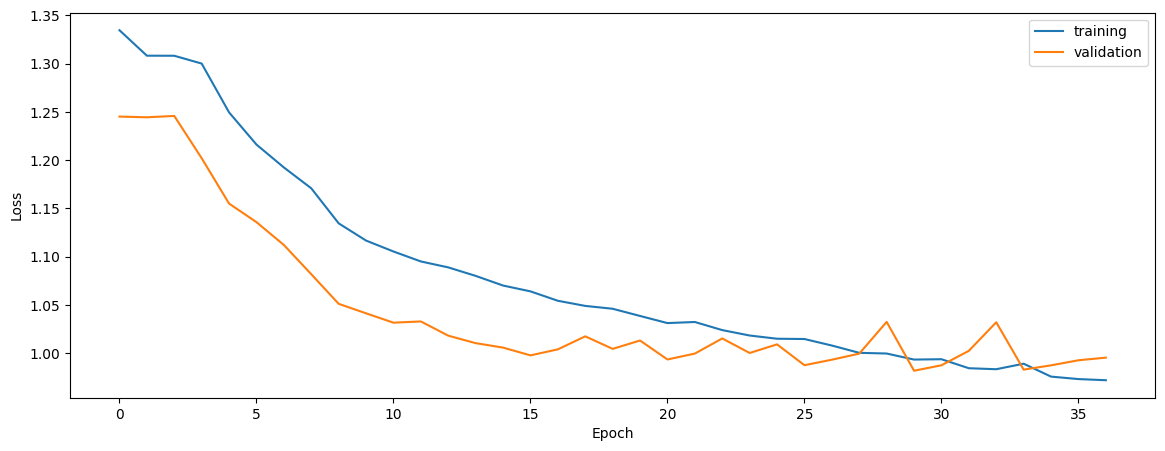

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


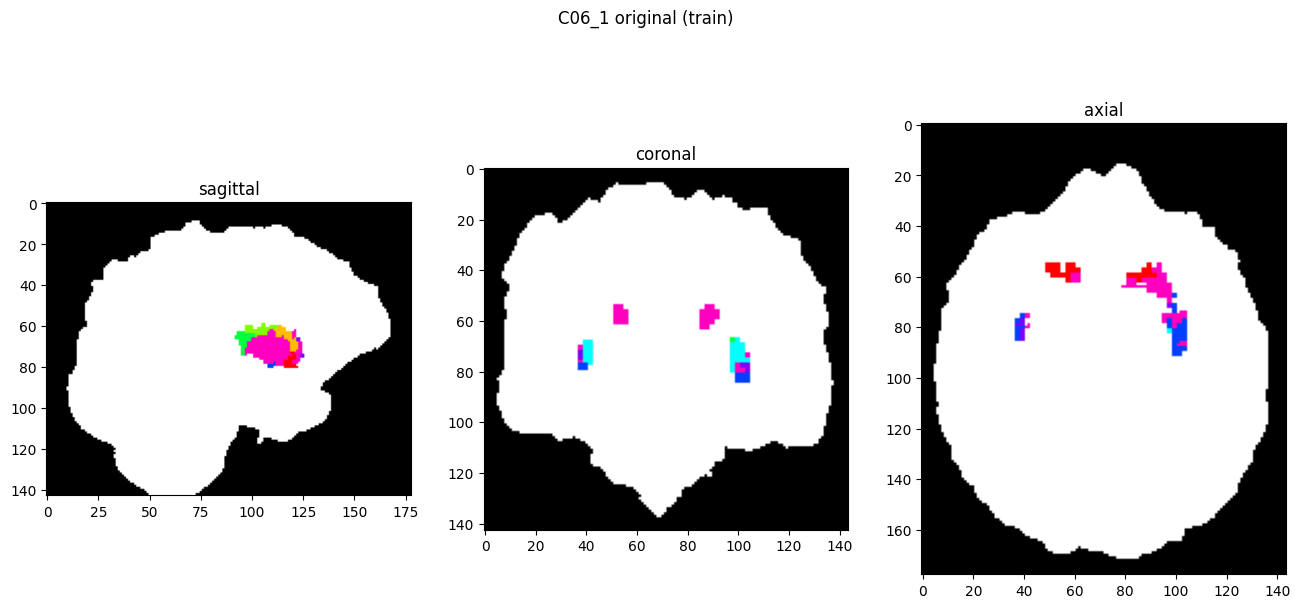

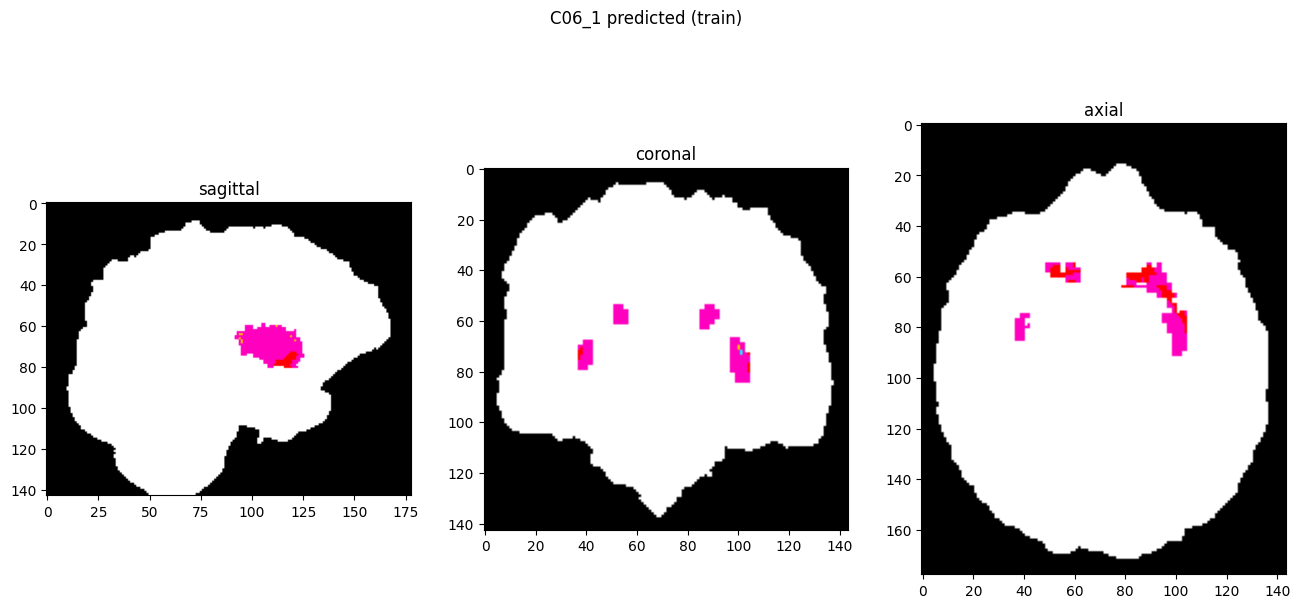

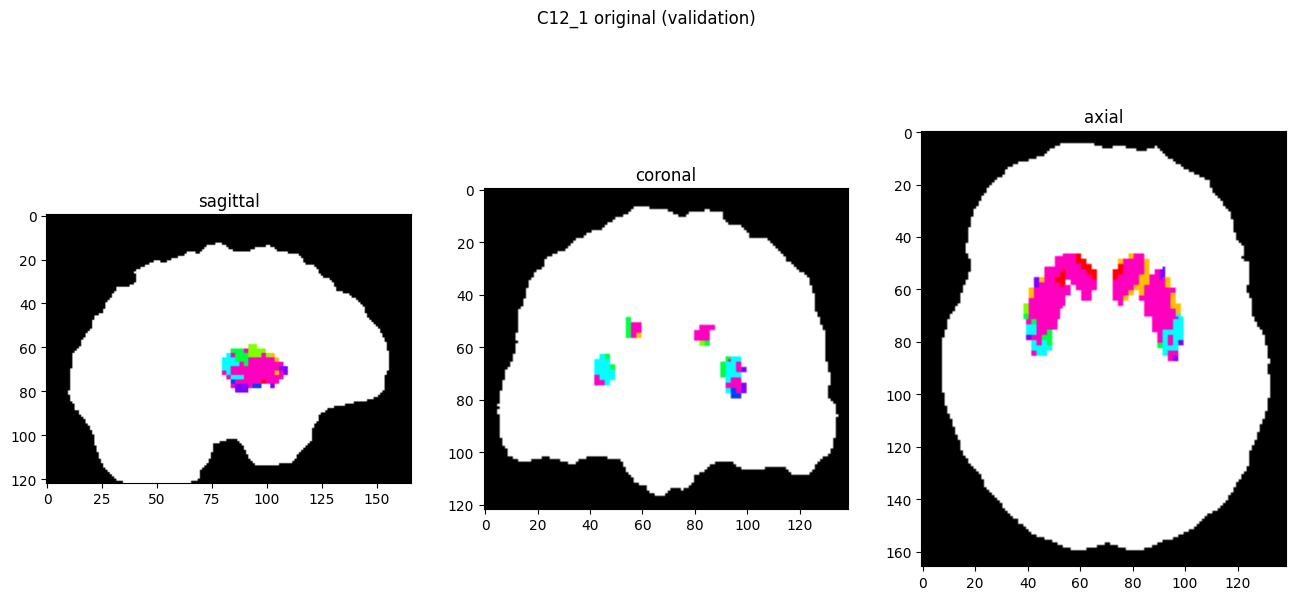

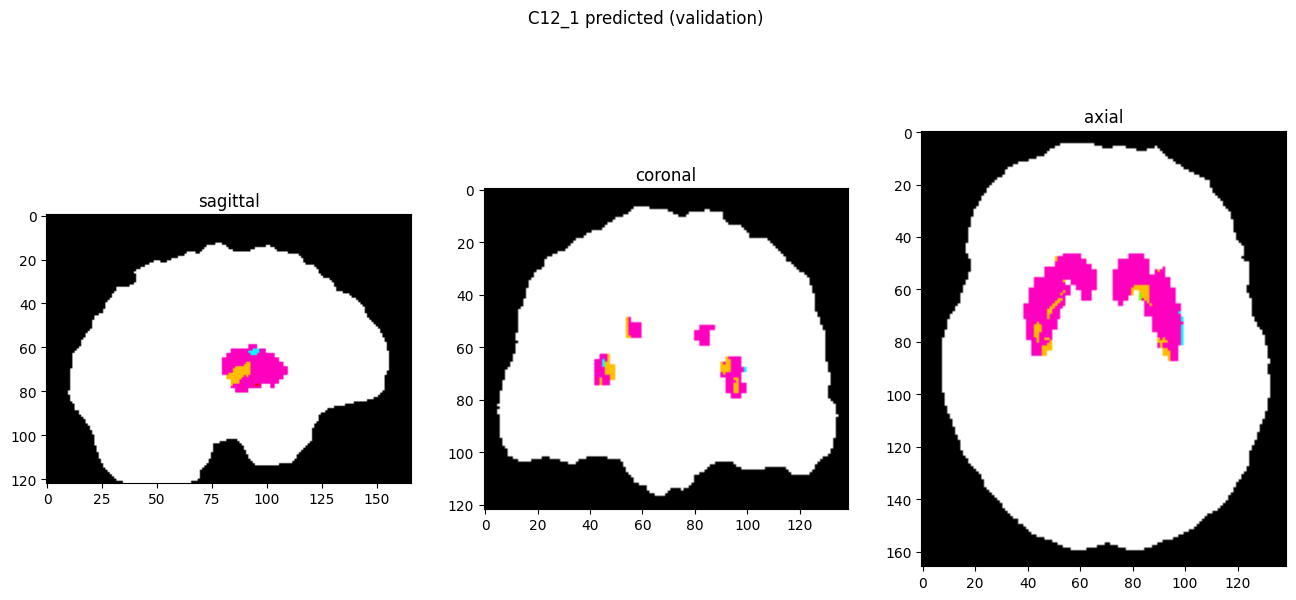

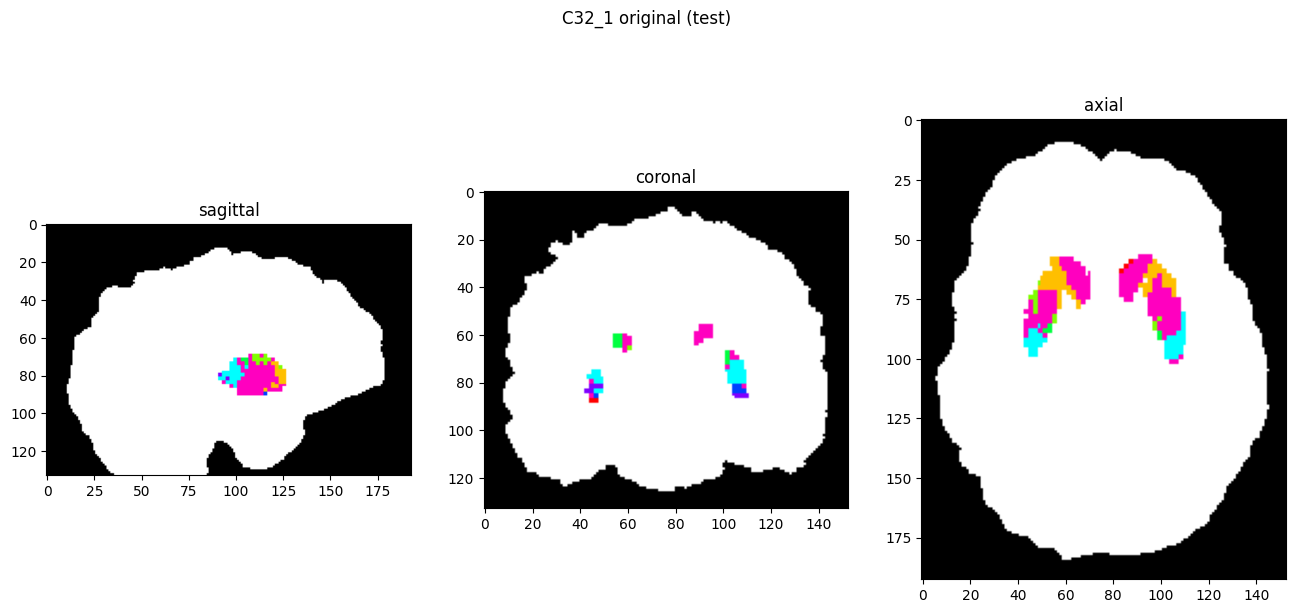

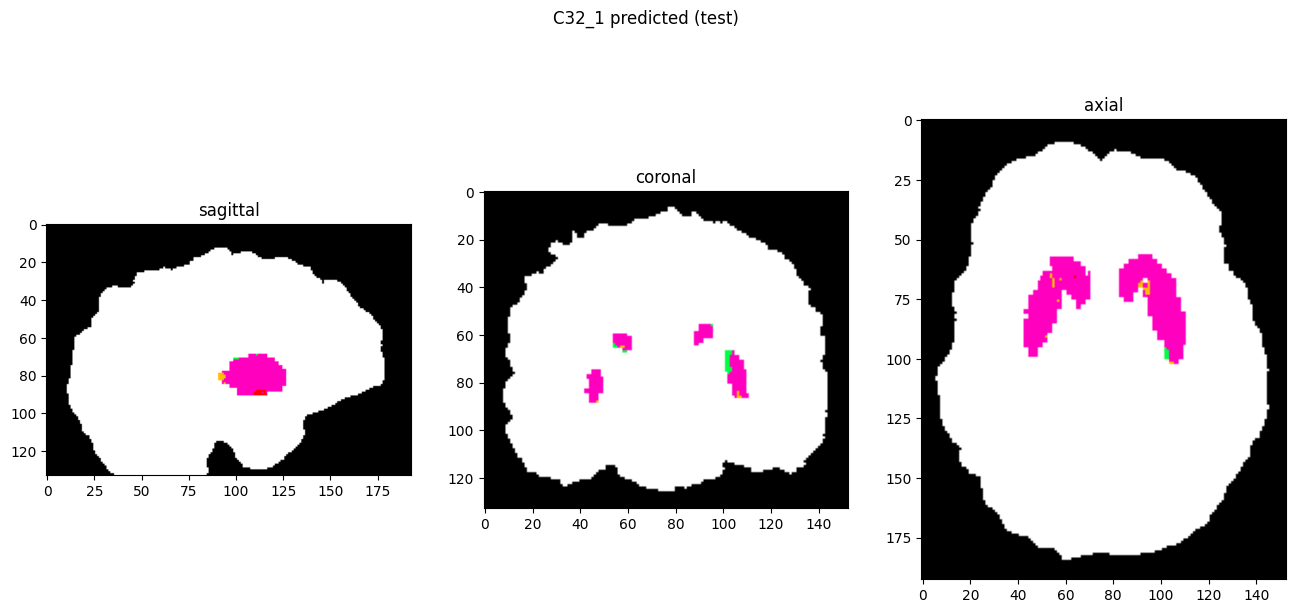

In [10]:
showResults(model, gen, threshold=0)